# K-Means Clustering

Tutorials:
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/ 
- https://medium.com/@messenger_g/k-means-clustering-on-pca-transformed-ecological-data-python-scikit-learn-9e982a1a2b15

In [534]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

%pip install kneed
from kneed import KneeLocator

# run pip install matplot ipywidgets (as admin)
from ipywidgets import interact


In [535]:
# Suppress memory leak warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [536]:
# Define possible dataset paths.
paths = [
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data.csv',                    # 0  - Annual  :
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data-gendered.csv',           # 1  - Annual  : Gendered
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data.csv',            # 2  - Monthly :
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data-gendered.csv'    # 3  - Monthly : Gendered
]

# Choose a dataset.
chosen_dataset = 0

# Load the data
df = pd.read_csv(paths[chosen_dataset])

# Count of number of pollutant features in the dataset
column_list = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']
n_pollutants = sum([1 for col in df.columns if col in column_list])

# Extract pollutant columns and columns after the pollutants
pollutant_columns = [col for col in df.columns if col in column_list]
health_stat_columns = df.iloc[:, df.columns.get_loc(pollutant_columns[-1]) + 1:]

# Show the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of pollutant features: {n_pollutants}")
df.describe()

# Visualize the dataset
#sns.pairplot(df, diag_kind='kde', kind='scatter')
#plt.show()

Dataset shape: (130, 16)
Number of pollutant features: 6


CO ppm     NO pphm    NO2 pphm  OZONE pphm  PM10 µg/m³    SO2 pphm  \
count  130.000000  130.000000  130.000000  130.000000  130.000000  130.000000   
mean     0.133039    0.547513    0.585202    1.854216   18.511935    0.068814   
std      0.066545    0.671731    0.326022    0.249853    3.468044    0.038708   
min      0.000000    0.055302    0.173631    1.279167   11.923039    0.000000   
25%      0.101596    0.190634    0.327954    1.711455   16.729167    0.039810   
50%      0.133039    0.342790    0.506030    1.861842   18.511935    0.068814   
75%      0.173716    0.632921    0.767641    2.019923   18.981145    0.091701   
max      0.326036    3.079731    1.569617    2.411666   30.798971    0.189220   

       asthma deaths  asthma edp  asthma hospitalisations    asthma pic  \
count     130.000000  130.000000               130.000000    130.000000   
mean        0.759615  363.168462               111.835833   8964.038462   
std         0.241591  133.023553                32.369546   1711.960536   
min         0.300000  126.000000                51.775000   4650.000000   
25%         0.650000  256.100000                89.462500   7887.500000   
50%         0.650000  357.050000               108.675000   9187.500000   
75%         0.868750  448.237500               129.791667   9971.875000   
max         1.425000  740.700000               220.258333  14187.500000   

       copd deaths  copd hospitalisations  iap deaths  iap hospitalisations  
count   130.000000             130.000000  130.000000            130.000000  
mean     25.509231             223.239231    8.498846            324.651538  
std       7.744691              81.116937    2.250424             84.065457  
min       9.400000              60.500000    4.200000            156.300000  
25%      19.225000             162.300000    6.981250            274.200000  
50%      26.950000             232.000000    8.375000            322.100000  
75%      30.356250             266.700000    9.975000            367.775000  
max      51.300000             412.000000   15.000000            540.200000

Component	Explained Variance	Cumulative Variance
1		0.500			0.500
2		0.256			0.756
3		0.121			0.878
4		0.070			0.947
5		0.035			0.982
6		0.018			1.000


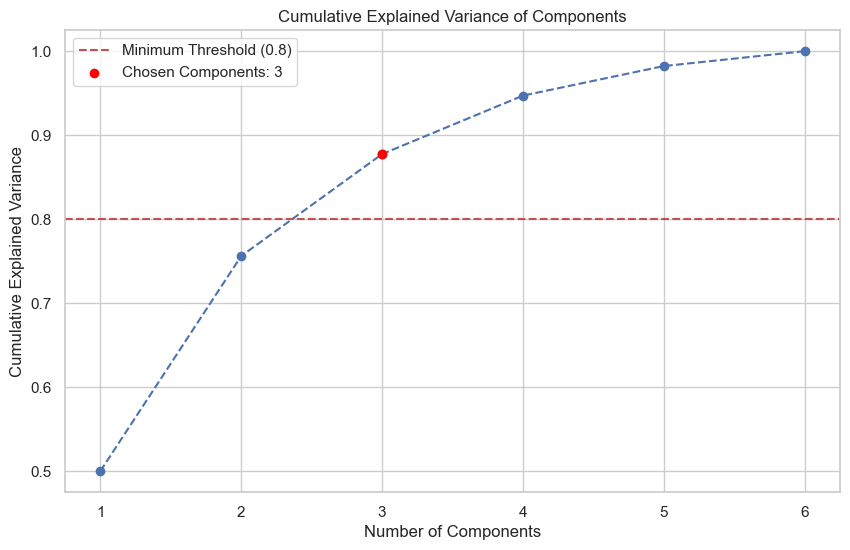

In [537]:
# Scale pollutants data.
scaler = StandardScaler()
pollutant_columns_scaled = scaler.fit_transform(df[pollutant_columns])

# Find the optimal number of clusters.
pca = PCA()
pca.fit(pollutant_columns_scaled)
explained_variance = pca.explained_variance_ratio_

# Print the explained variance of components.
cumulative_variance = 0
n_components = None
print("Component\tExplained Variance\tCumulative Variance")
for i, variance in enumerate(explained_variance):
    cumulative_variance += variance
    print(f"{i + 1}\t\t{variance:.3f}\t\t\t{cumulative_variance:.3f}")

    if cumulative_variance >= 0.8 and n_components is None:
        n_components = i + 1  # Store the first component that brings the cumulative variance above 0.8

# Plot the cumulative explained variance of components.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of Components')
plt.axhline(y=0.8, color='r', linestyle='--', label='Minimum Threshold (0.8)')
# plt.fill_between(range(1, len(explained_variance) + 1), explained_variance[0], 0.8, color='grey', alpha=0.15)

# Highlight the chosen number of components.
plt.scatter(n_components, explained_variance.cumsum()[n_components - 1], color='red', label=f'Chosen Components: {n_components}', zorder=5)
plt.legend()

plt.show()

In [538]:
pca = PCA(n_components=3)
pca.fit(pollutant_columns_scaled)
pca.transform(pollutant_columns_scaled)
scores_pca = pca.transform(pollutant_columns_scaled)

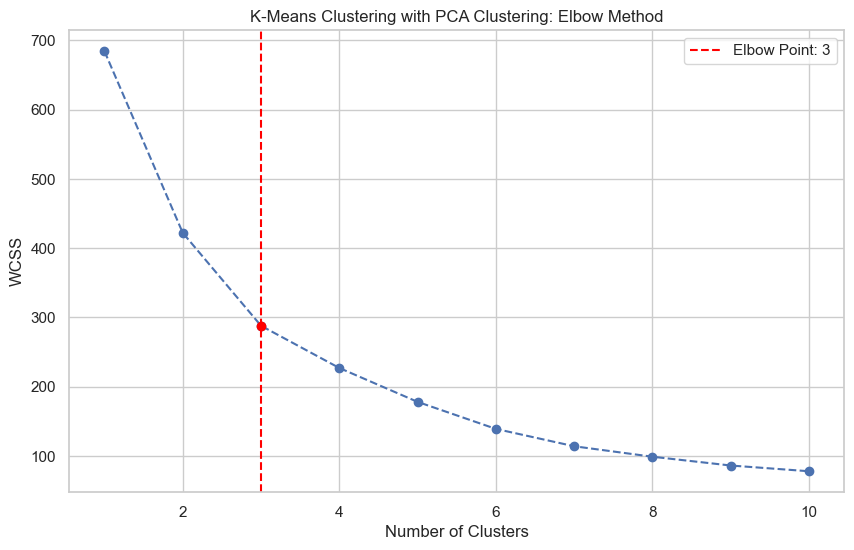

The elbow point is at 3 clusters.


In [539]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Clustering with PCA Clustering: Elbow Method')

# Identify the elbow point using KneeLocator
kl = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
elbow = kl.elbow

# Mark the elbow point on the plot
plt.axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')
plt.legend()

# Highlight the chosen number of components.
plt.scatter(n_components, wcss[n_components - 1], color='red', zorder=5)

# Show the plot
plt.show()

# Print the identified elbow point
print(f'The elbow point is at {elbow} clusters.')

In [540]:
kmeans_pca = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pca.fit(scores_pca)

df = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df.columns.values[-3:] = ['component 1', 'component 2', 'component 3']
df['cluster'] = kmeans_pca.labels_
df['cluster'] = df['cluster'].map({0: 'First', 1: 'Second', 2: 'Third'})
df.head()

financial year            lhd    CO ppm   NO pphm  NO2 pphm  OZONE pphm  \
0      2014/2015  Central Coast  0.100000  0.233333  0.466667    1.791190   
1      2015/2016  Central Coast  0.108333  0.216667  0.458333    1.691667   
2      2016/2017  Central Coast  0.100000  0.216667  0.491667    1.775000   
3      2017/2018  Central Coast  0.108333  0.175000  0.441667    1.861183   
4      2018/2019  Central Coast  0.108333  0.216667  0.416667    1.733333   

   PM10 µg/m³  SO2 pphm  asthma deaths  asthma edp  asthma hospitalisations  \
0   15.158333  0.050000          0.675       366.6                  117.375   
1   15.375000  0.058333          0.725       380.9                  121.225   
2   15.358333  0.058333          0.700       378.4                  118.225   
3   16.816667  0.075000          0.675       368.2                  113.575   
4   17.750000  0.091667          0.675       378.8                  107.725   

   asthma pic  copd deaths  copd hospitalisations  iap deaths  \
0      9562.5         33.0                  292.1        10.2   
1      9200.0         33.1                  293.2        10.1   
2      8762.5         35.5                  306.9        11.3   
3      8100.0         36.4                  309.7        11.3   
4      7700.0         35.4                  295.8        10.1   

   iap hospitalisations  component 1  component 2  component 3 cluster  
0                 329.0    -0.609508    -1.142571    -0.314641   Third  
1                 345.3    -0.374036    -1.098622    -0.309889   Third  
2                 287.0    -0.521267    -0.996436    -0.419392   Third  
3                 376.8    -0.683274    -0.296048    -0.415417   Third  
4                 376.0    -0.404505    -0.042532    -0.493930   Third

C:\Users\matth\AppData\Local\Temp\ipykernel_15848\601391130.py:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

c:\Users\matth\anaconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning:

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.



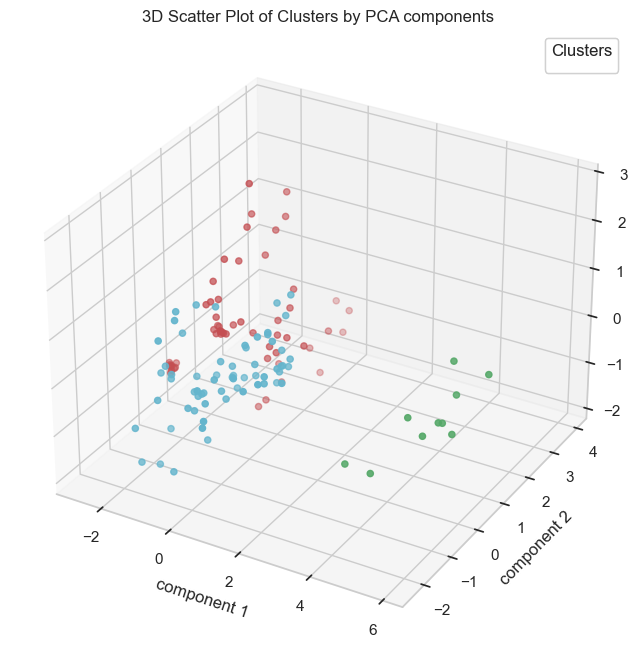

In [546]:
from mpl_toolkits.mplot3d import Axes3D

# Visualize the clusters in 3D.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_axis = df['component 1']
y_axis = df['component 2']
z_axis = df['component 3']

scatter = ax.scatter(x_axis, y_axis, z_axis, c=df['cluster'].map({'First': 'g', 'Second': 'r', 'Third': 'c'}), cmap='viridis')

# Add labels and title
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3') # TODO: Fix the label.
ax.set_title('3D Scatter Plot of Clusters by PCA components')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

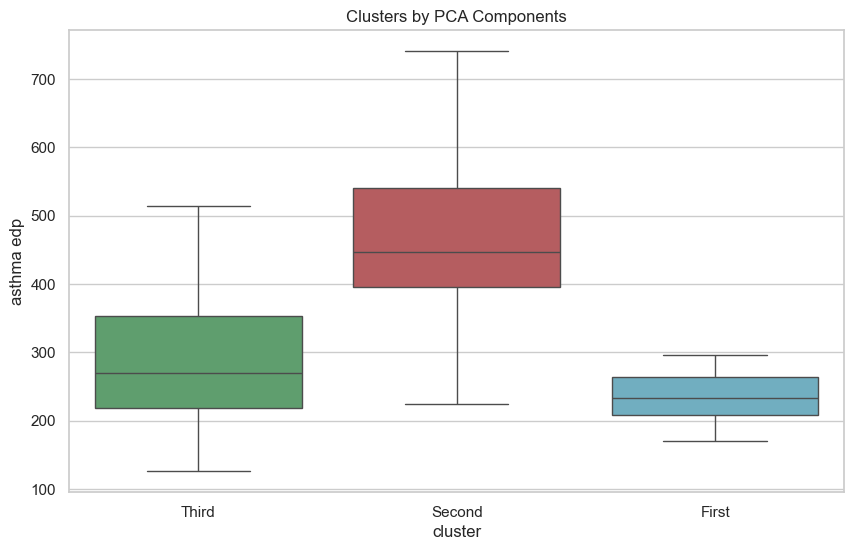

In [547]:
x_axis = df['cluster']
y_axis = df['asthma edp']
plt.figure(figsize=(10, 6))
sns.boxplot(x=x_axis, y=y_axis, hue=df['cluster'], palette=['g', 'r', 'c'])
plt.title('Clusters by PCA Components')
plt.show()

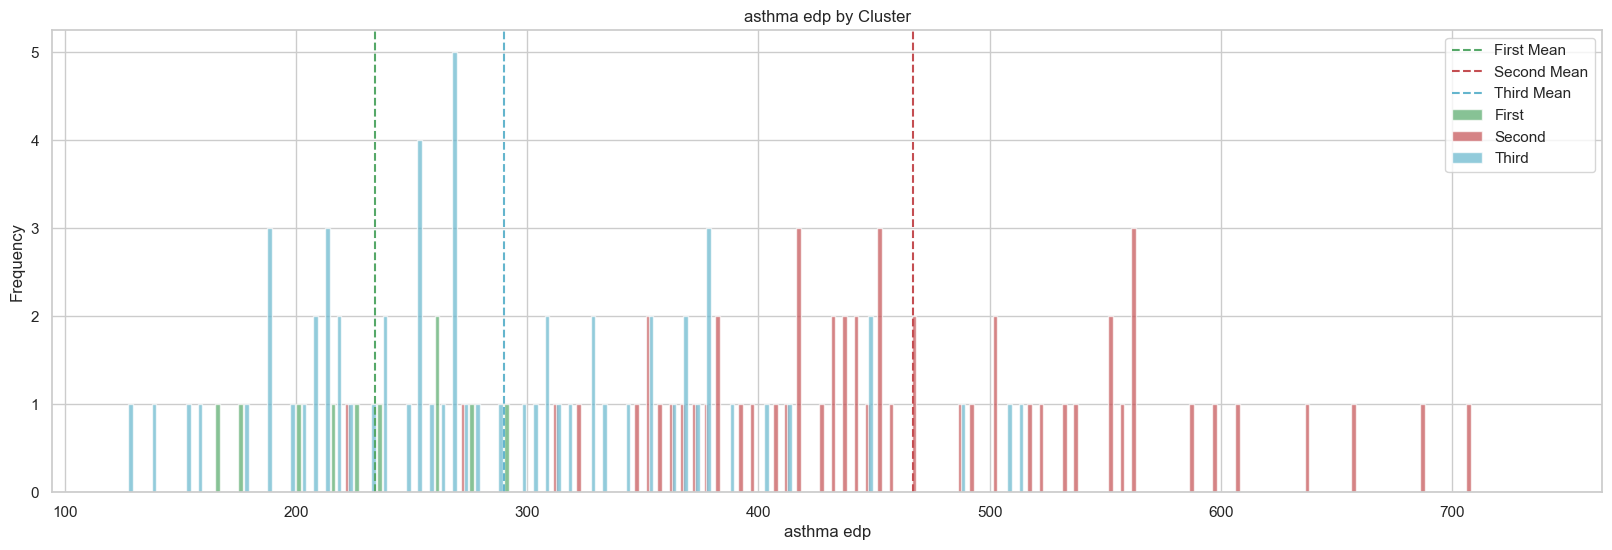

In [548]:
# Histogram for target variables
cluster_colors = ['g', 'r', 'c']
clusters = ['First', 'Second', 'Third']
feature = 'asthma edp'

# Create bins with a common range for all histograms.
min_value = df[feature].min()
max_value = df[feature].max()
bins = np.arange(int(min_value), int(max_value) + 1, 5)

# Set up the plot
plt.figure(figsize=(20, 6))
if len(bins) > 1:
    width = np.diff(bins)[0] / (len(clusters) + 1)

    # Plot histogram for each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster][feature]
        cluster_mean = cluster_data.mean()
        bar_positions = bins[:-1] + (i * width)
        plt.bar(bar_positions, np.histogram(cluster_data, bins=bins)[0], width=2, color=cluster_colors[i], label=cluster, alpha=0.7)
        plt.axvline(cluster_mean, color=cluster_colors[i], linestyle='--', label=f'{cluster} Mean')

    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} by Cluster')
    plt.legend()
    plt.show()
else:
    print("Bins array is empty. Adjust the range or bin size.")


In [459]:
max_clusters = 10
results = []

# Determine the optimal number of clusters using the Elbow method with the Kneedle algorithm
for pollutant in pollutant_columns:
    for health_stat in health_stat_columns.columns:

        # Extract and scale the data
        data = df[[pollutant, health_stat]]
        scaled_data = StandardScaler().fit_transform(data)

        # Elbow Method and Kneedle Algorithm for finding optimal number of clusters
        wcss = []
        for i in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=i, random_state=88)
            kmeans.fit(scaled_data)
            wcss.append(kmeans.inertia_)

        # Apply Kneedle algorithm to find the elbow point
        kneedle = KneeLocator(range(1, max_clusters + 1), wcss, curve='convex', direction='decreasing')
        optimal_clusters = kneedle.elbow

        # Apply K-Means clustering with the optimal number of clusters
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=88)
        kmeans.fit(scaled_data)

        # Calculate the silhouette score
        silhouette = silhouette_score(scaled_data, kmeans.labels_)

        # Calculate the Davies-Bouldin score
        db_score = davies_bouldin_score(scaled_data, kmeans.labels_)

        # Calculate the Calinski-Harabasz score
        ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)

        # Store the results (add your other metrics here as before)
        results.append({
            'pollutant': pollutant,
            'health_stat': health_stat,
            'scaled_data': scaled_data,
            'cluster_centers': kmeans.cluster_centers_,
            'labels': kmeans.labels_,
            'wcss': wcss,
            'optimal_clusters': optimal_clusters,
            'silhouette': silhouette,
            'db_score': db_score,
            'ch_score': ch_score
        })

KeyboardInterrupt: 

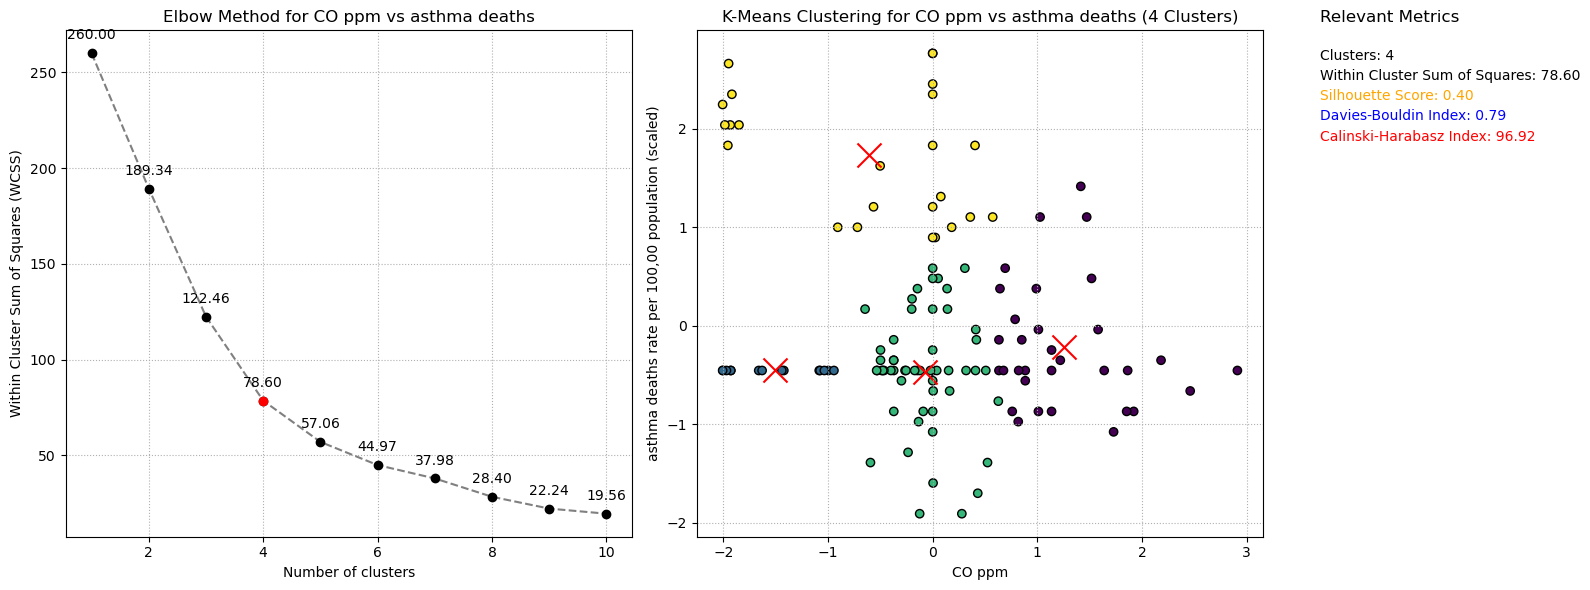

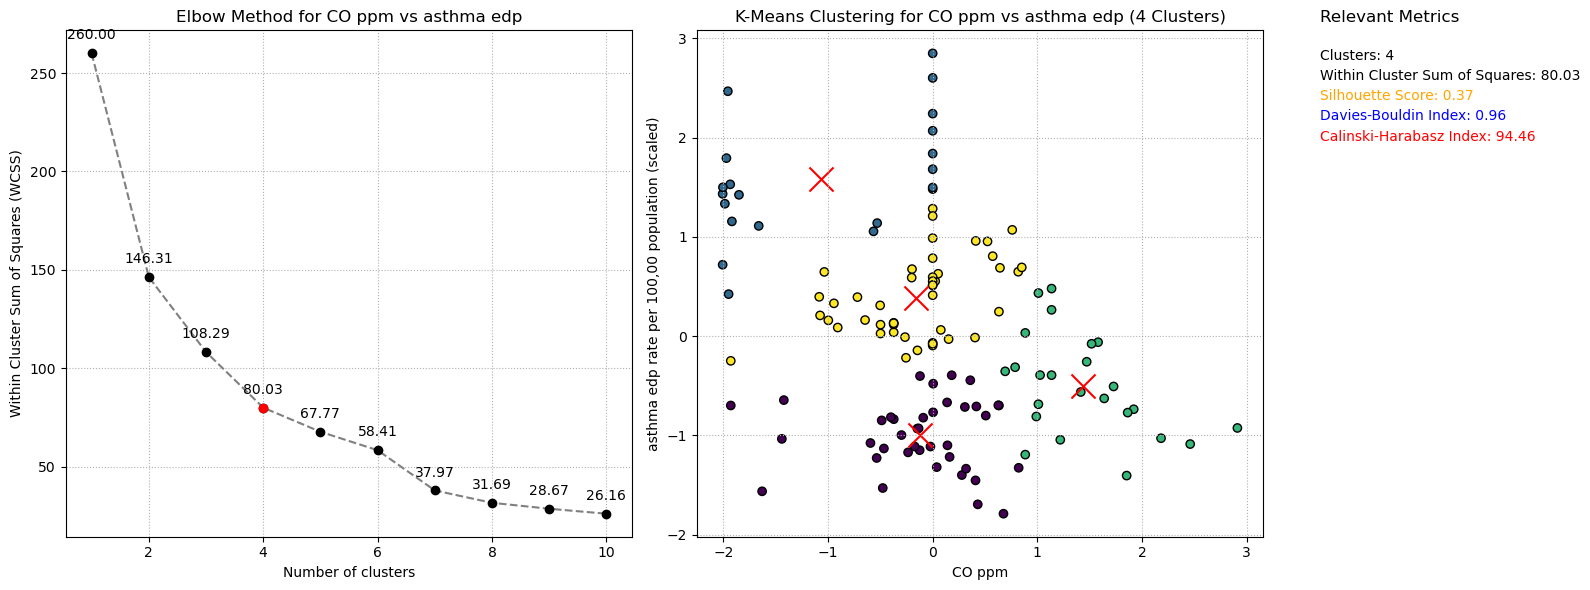

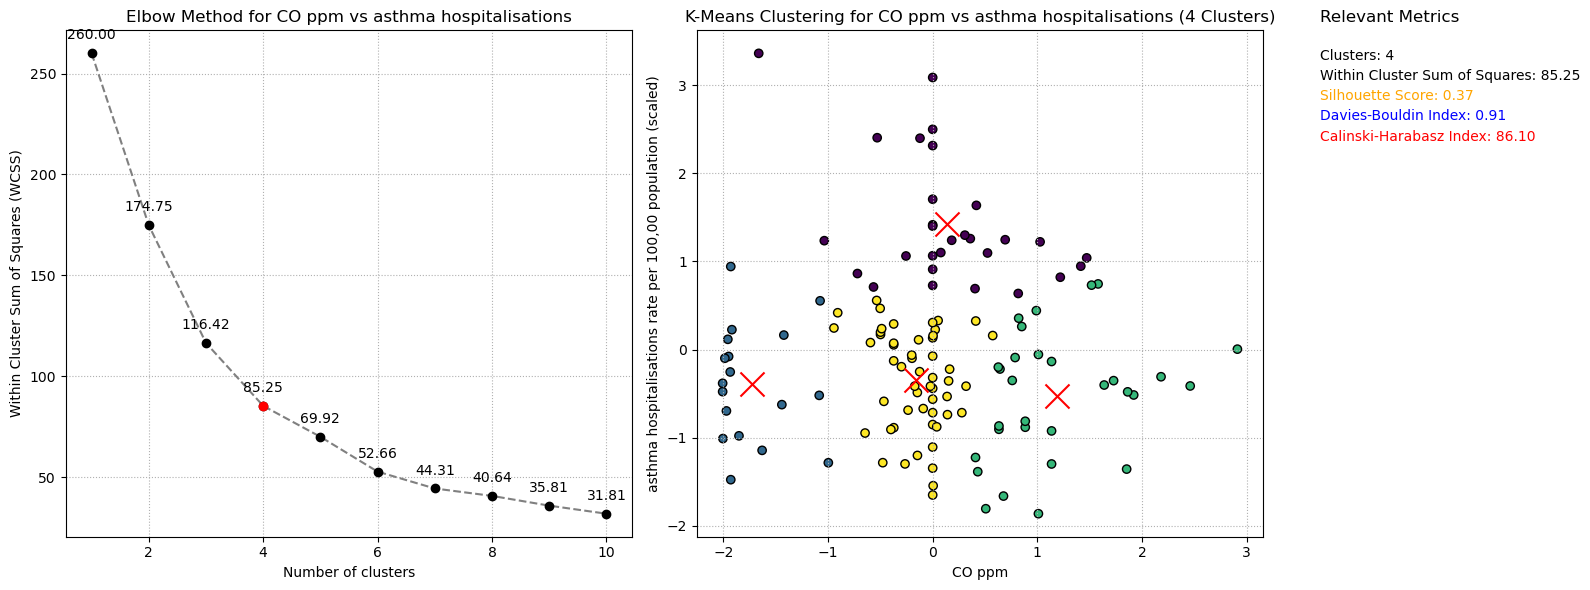

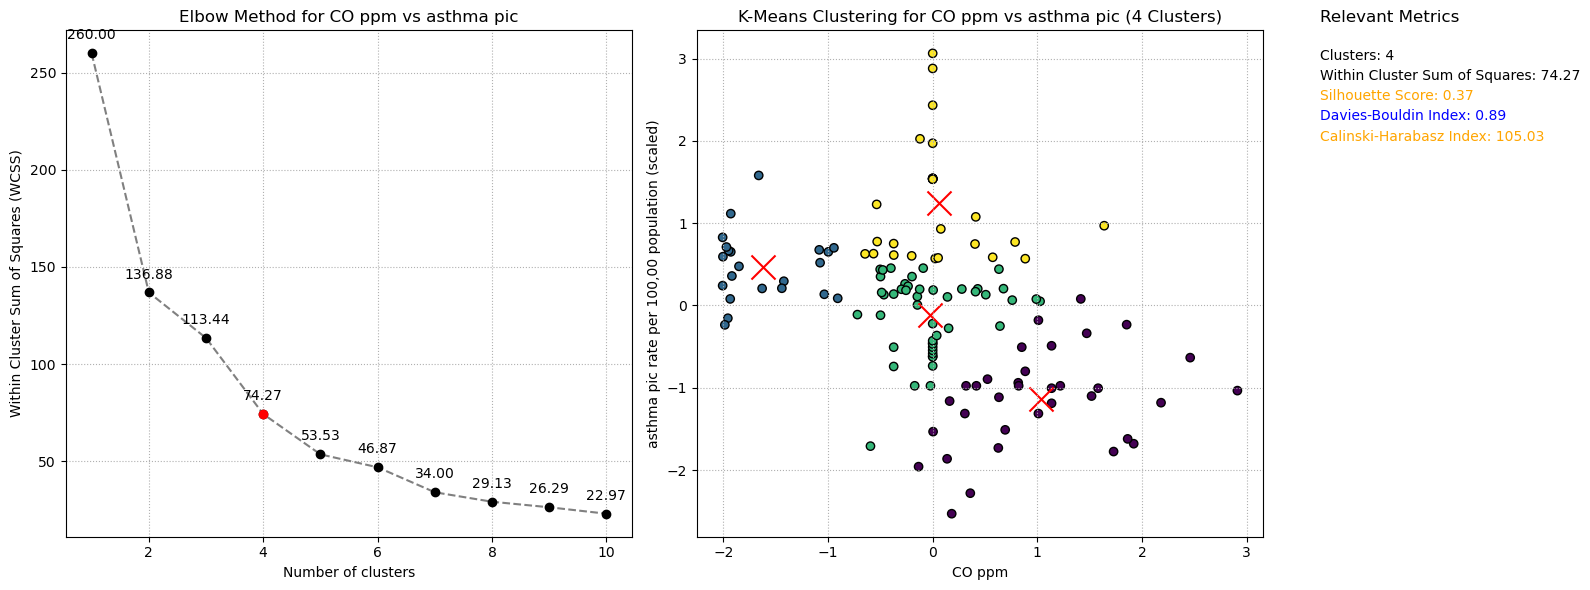

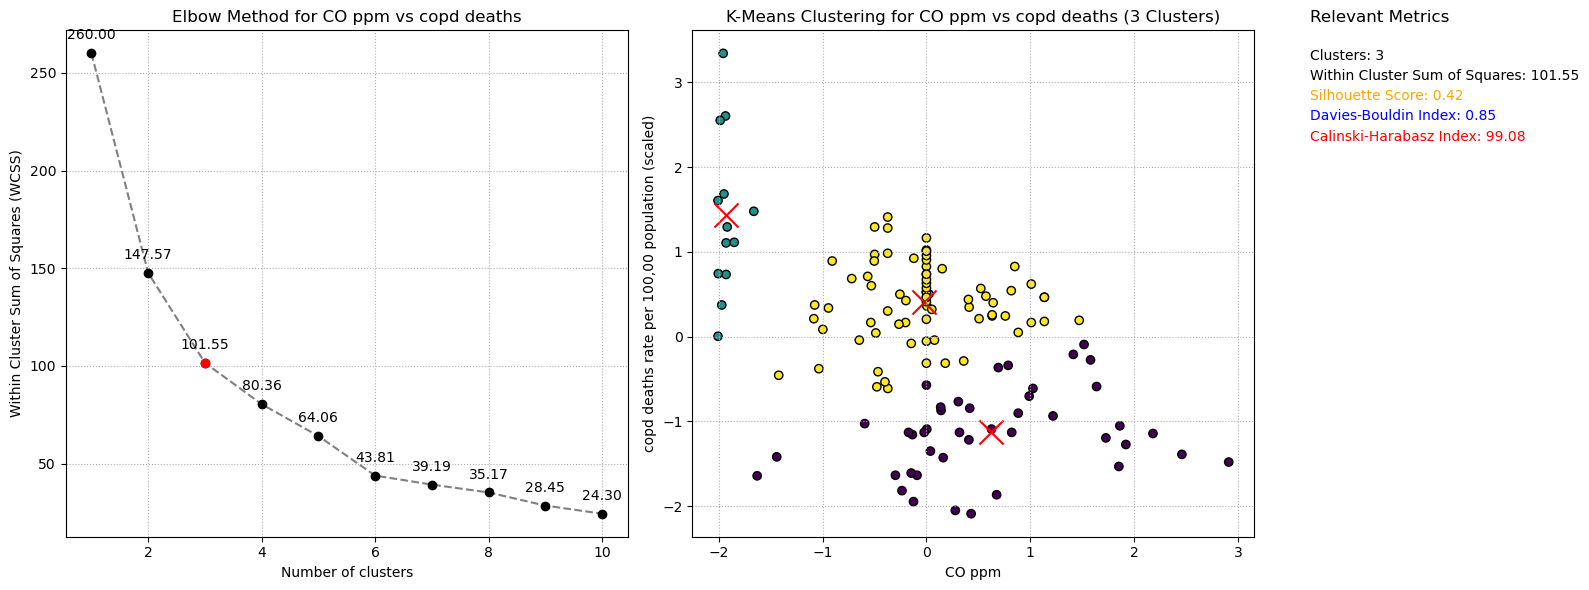

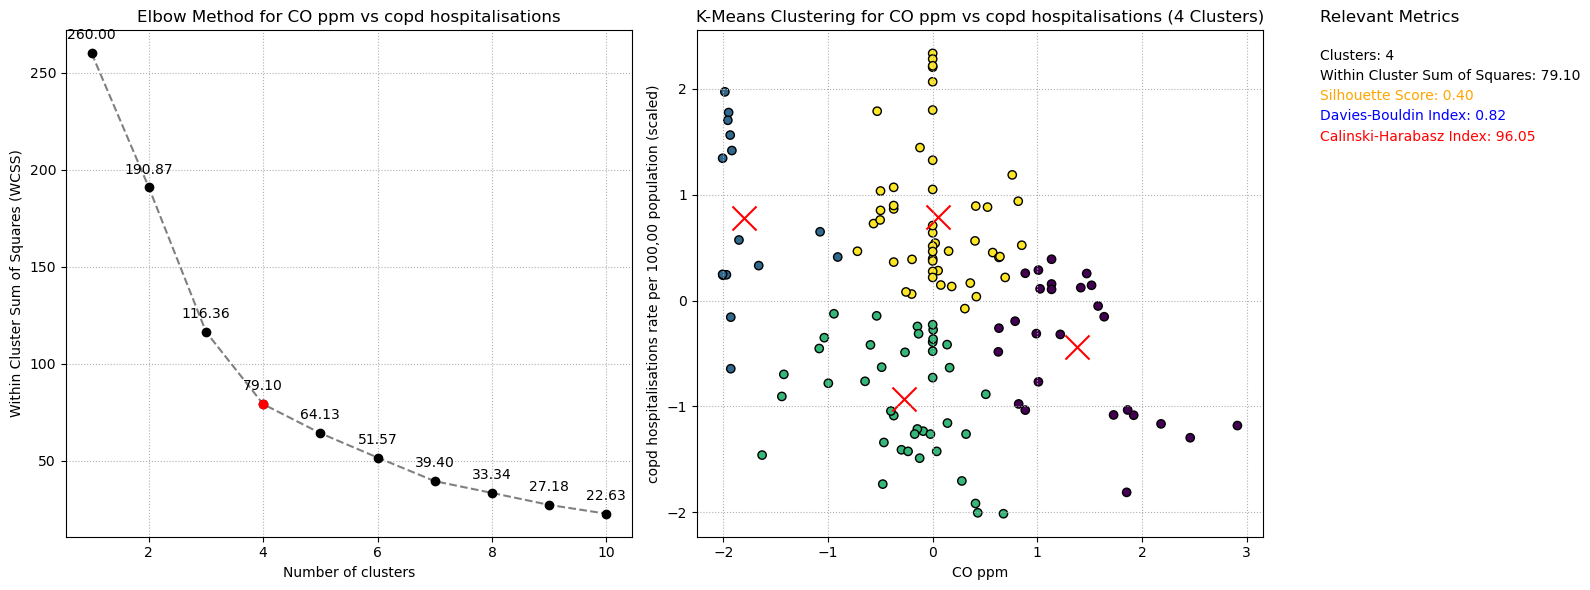

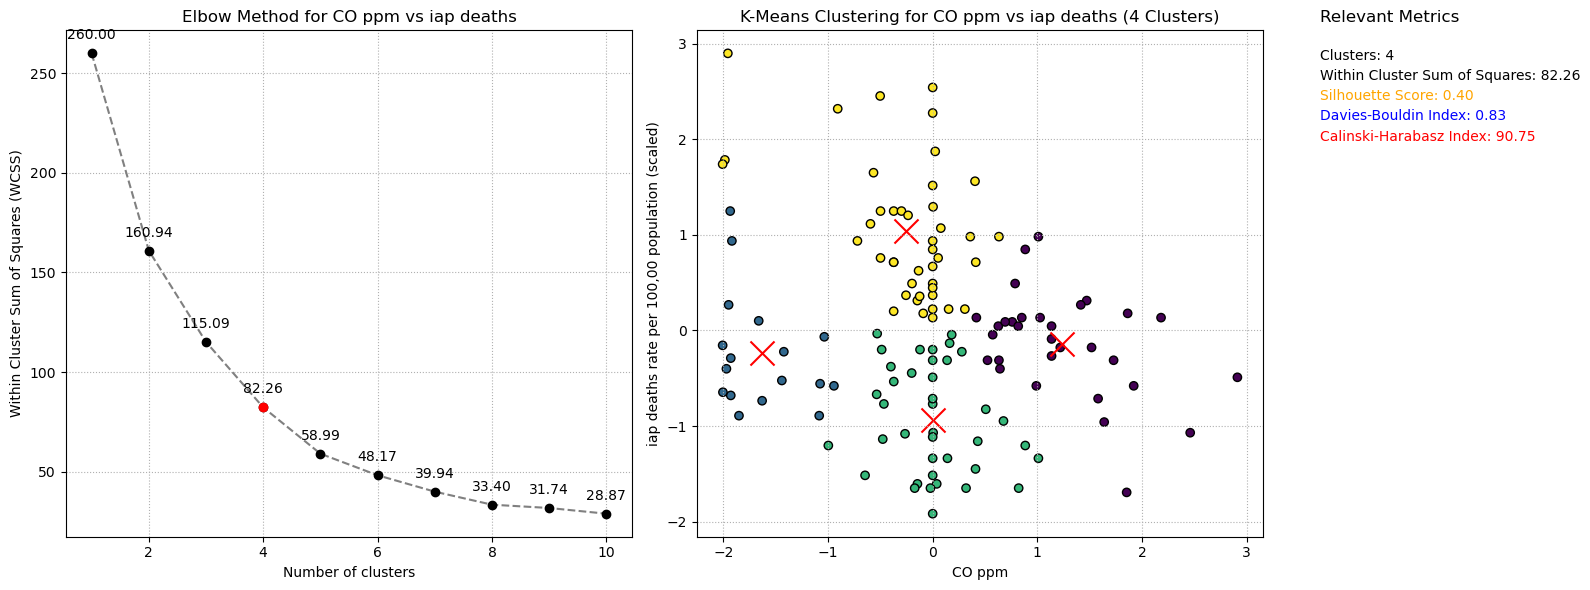

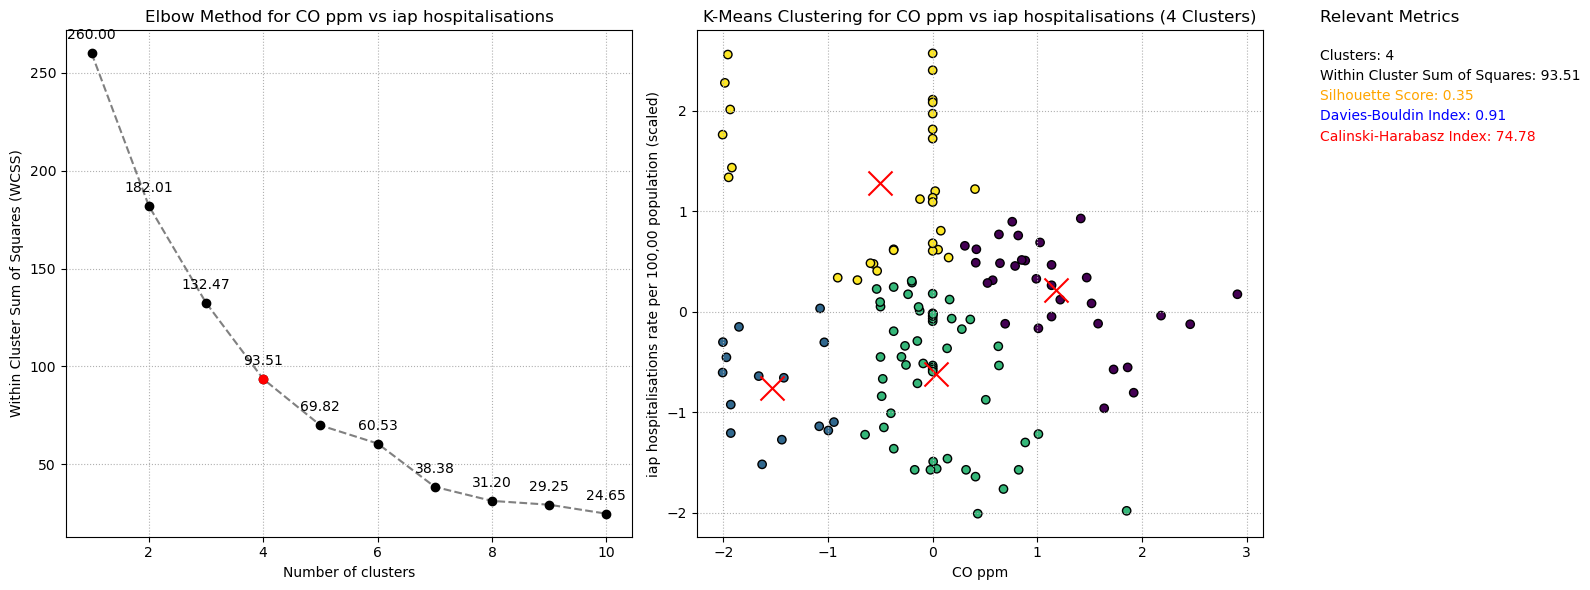

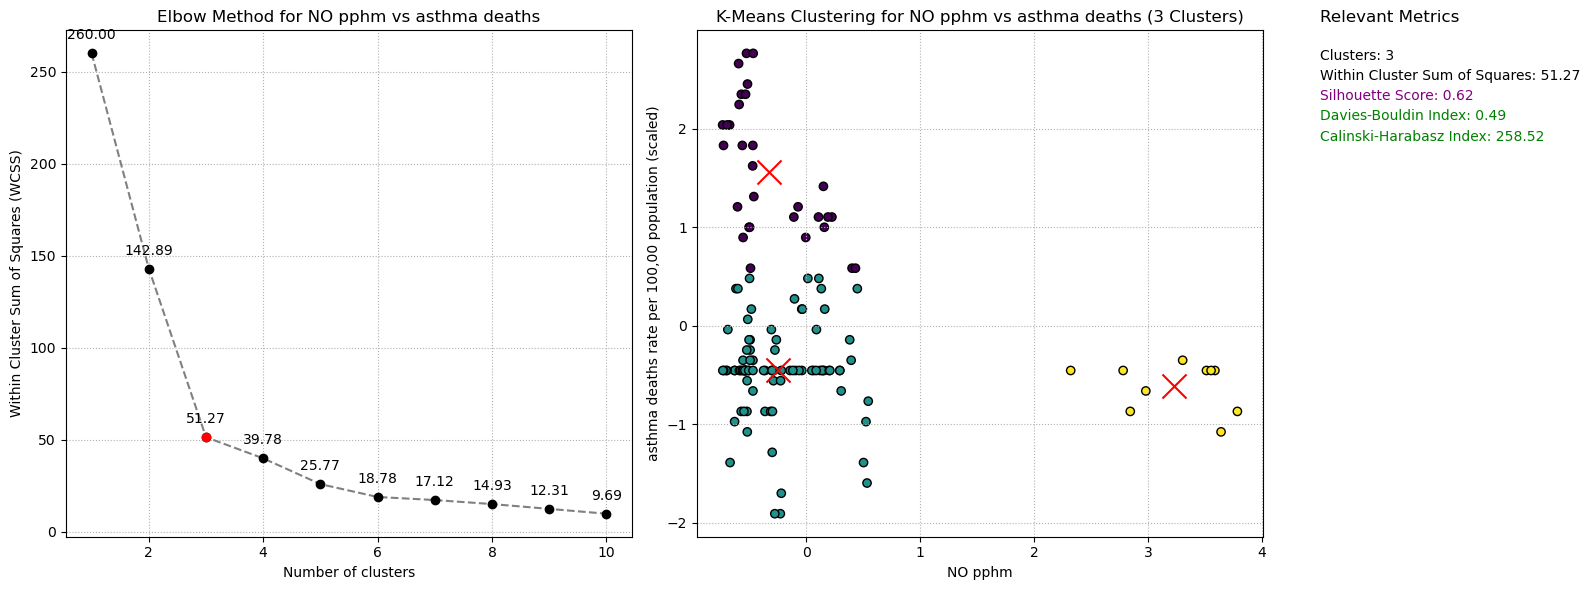

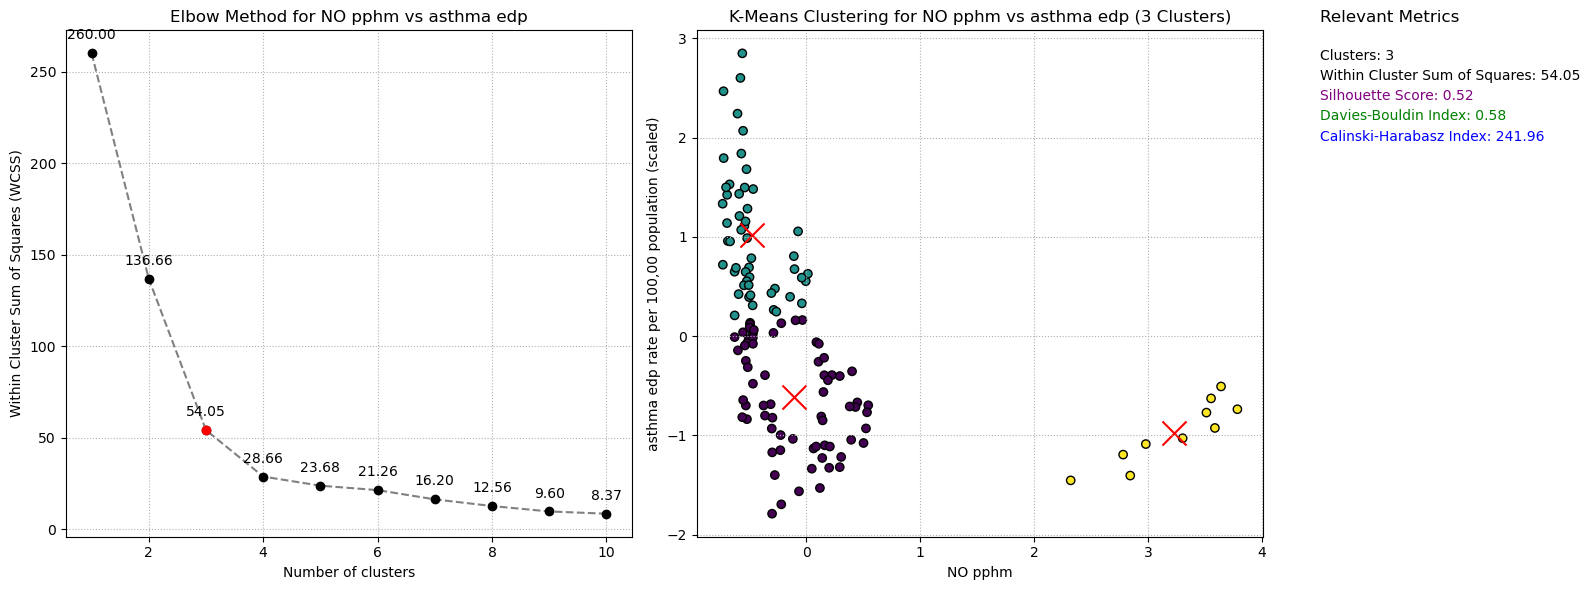

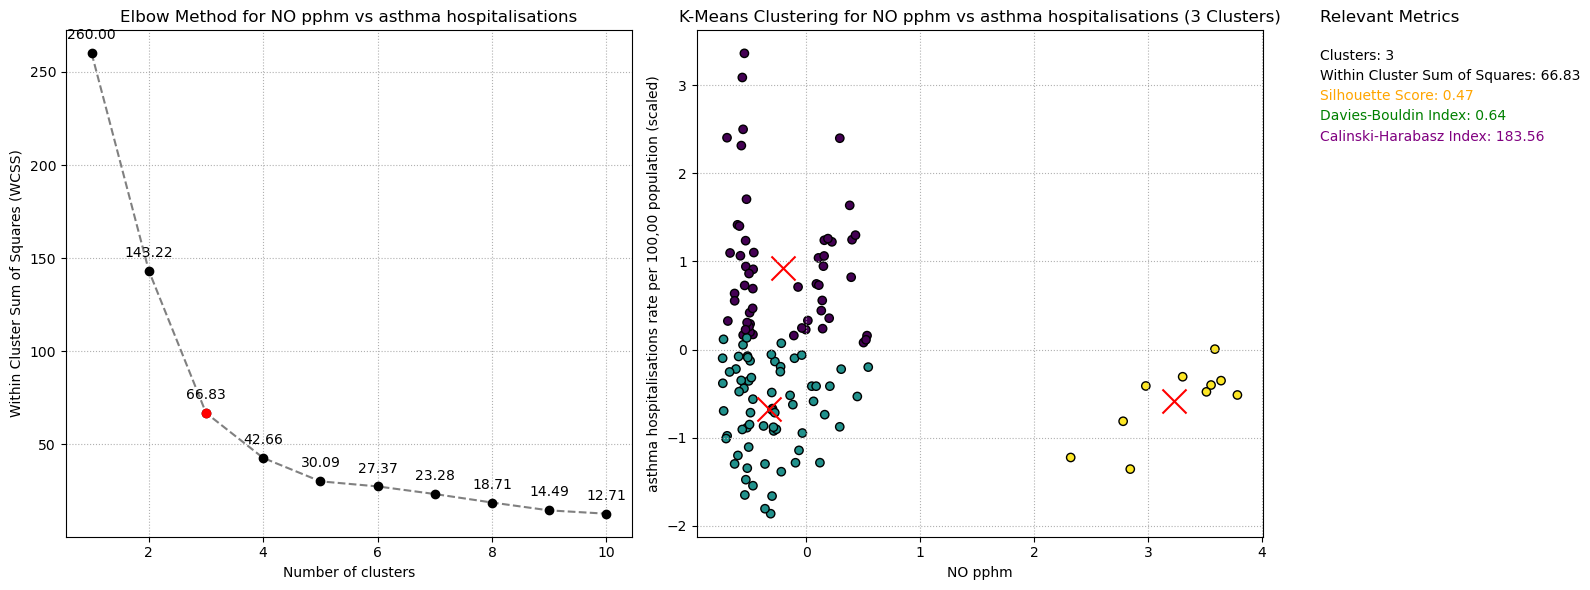

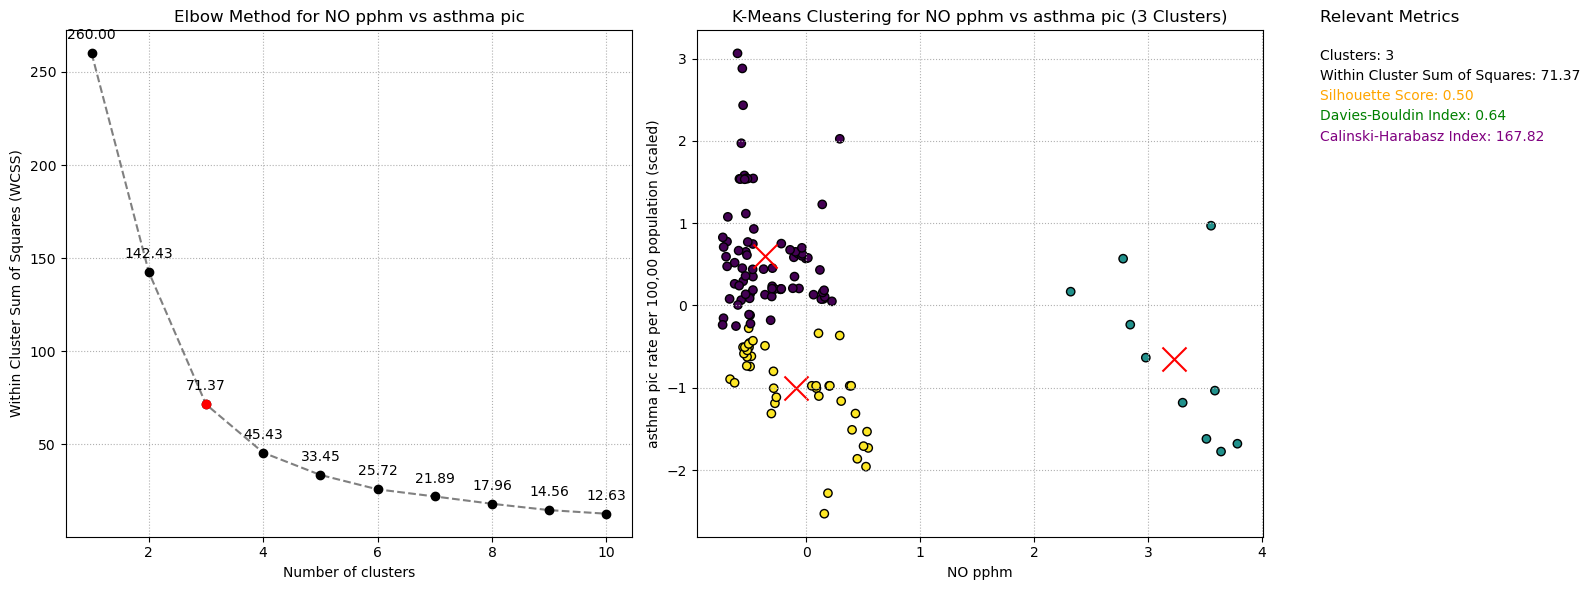

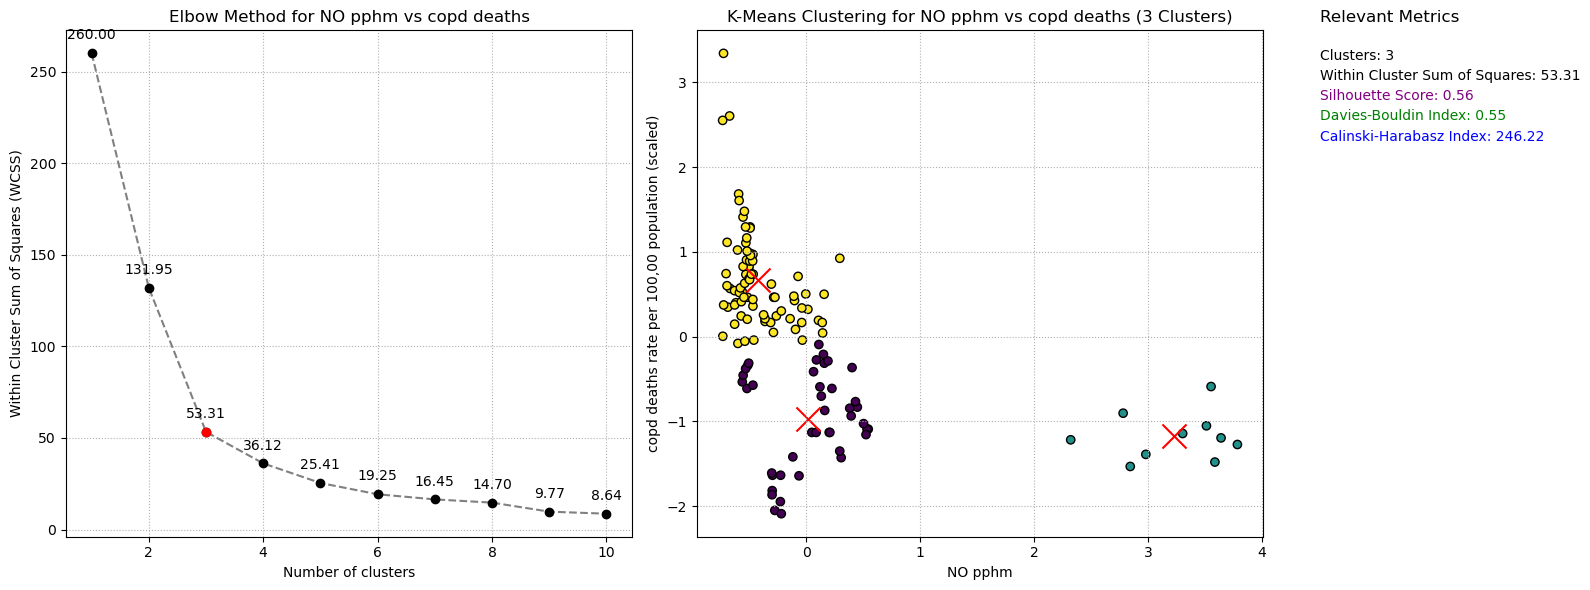

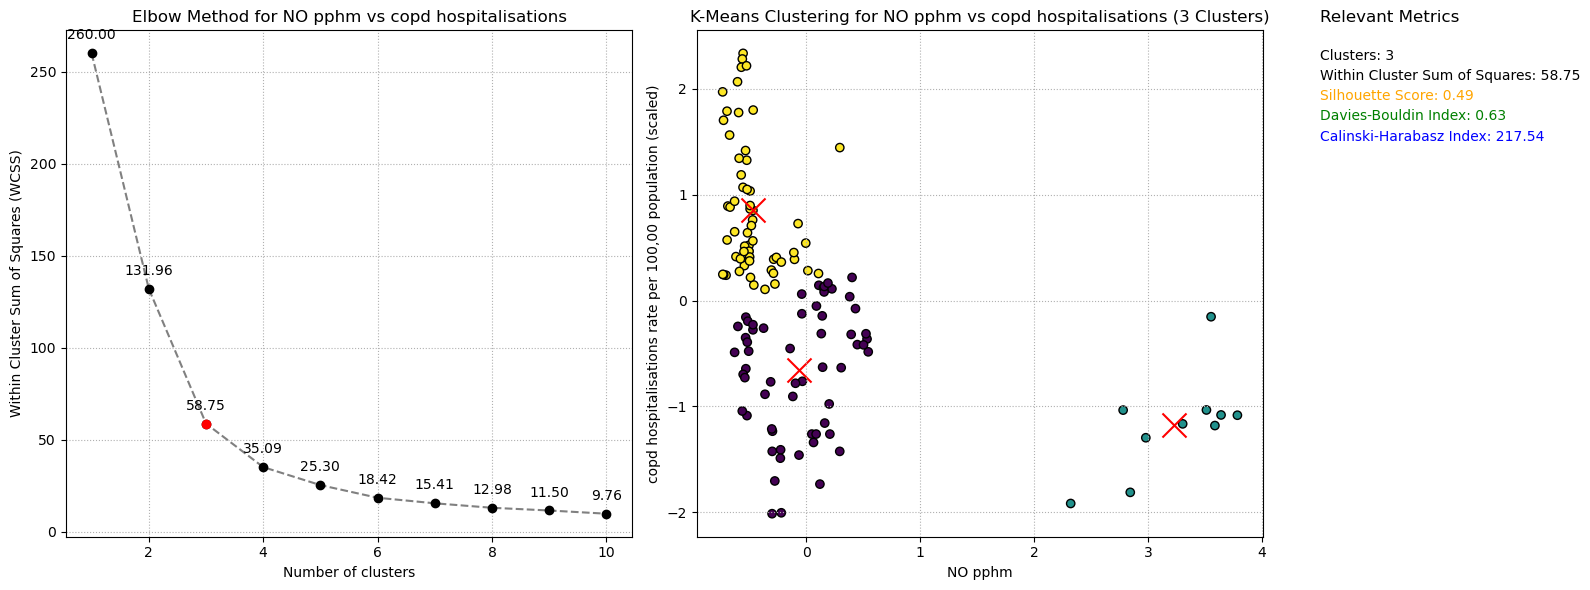

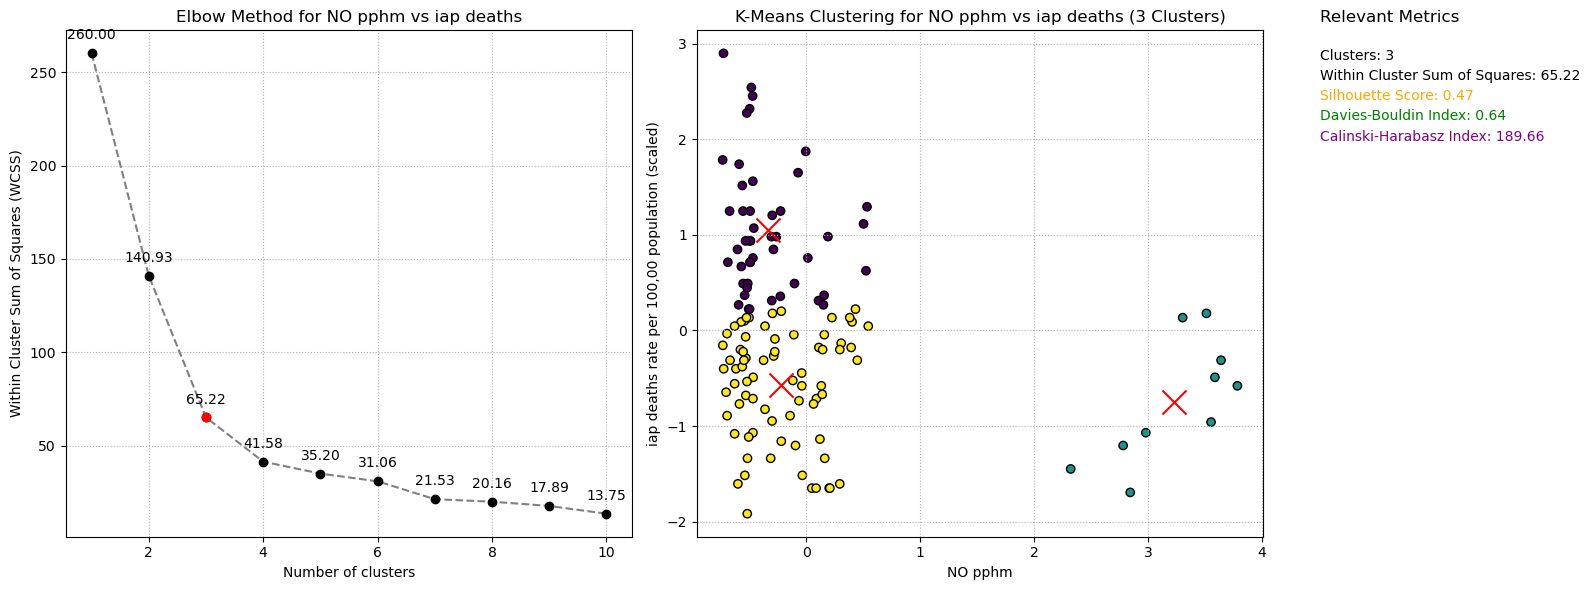

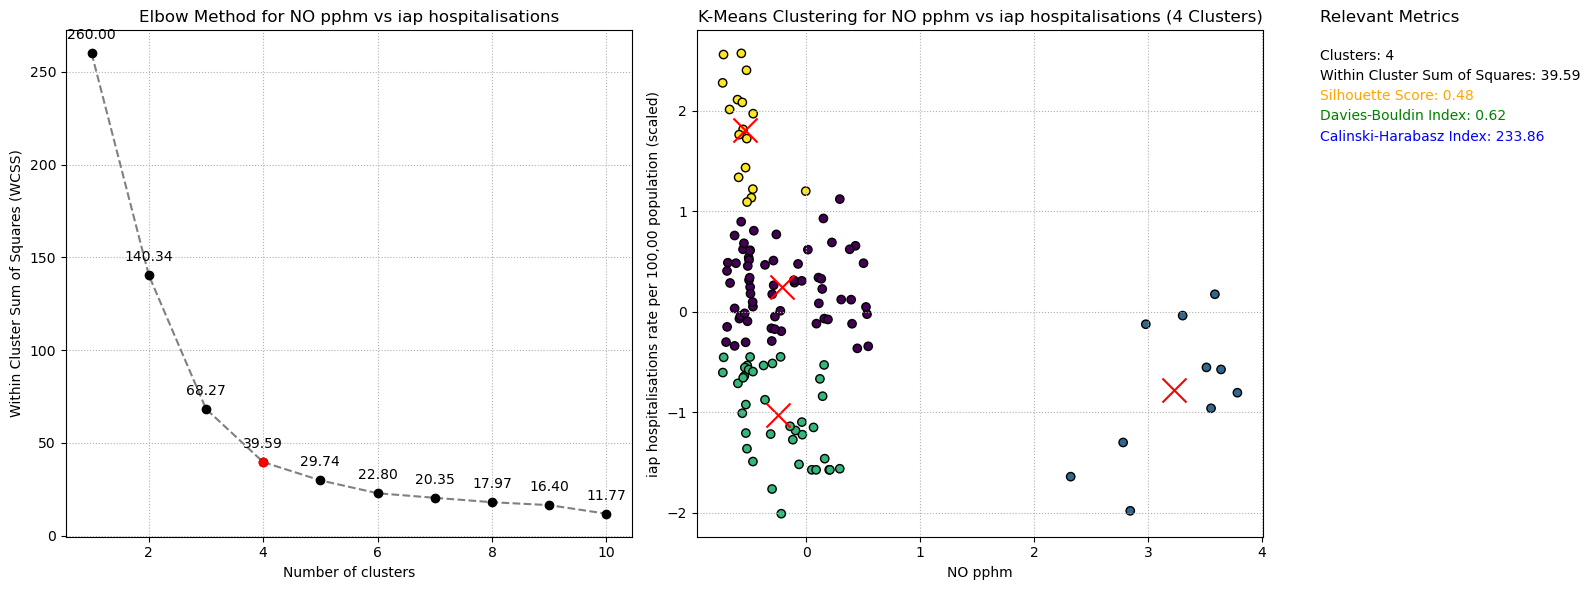

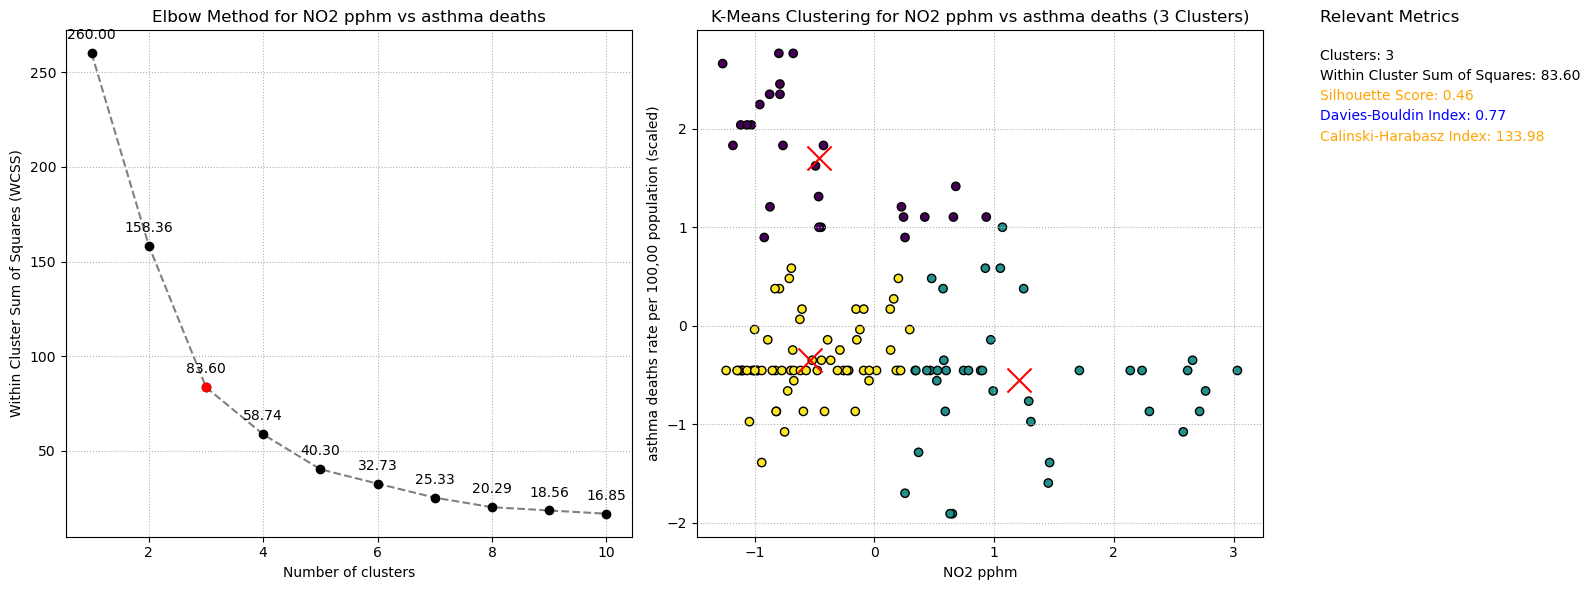

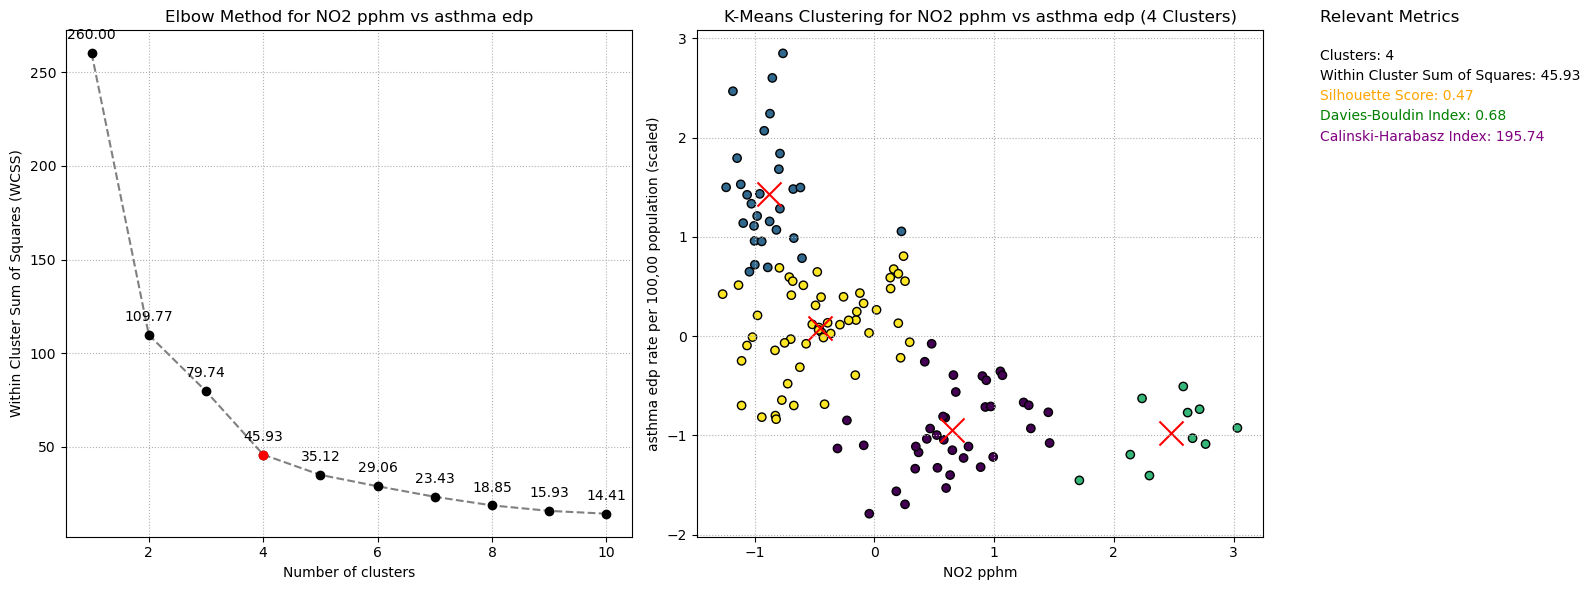

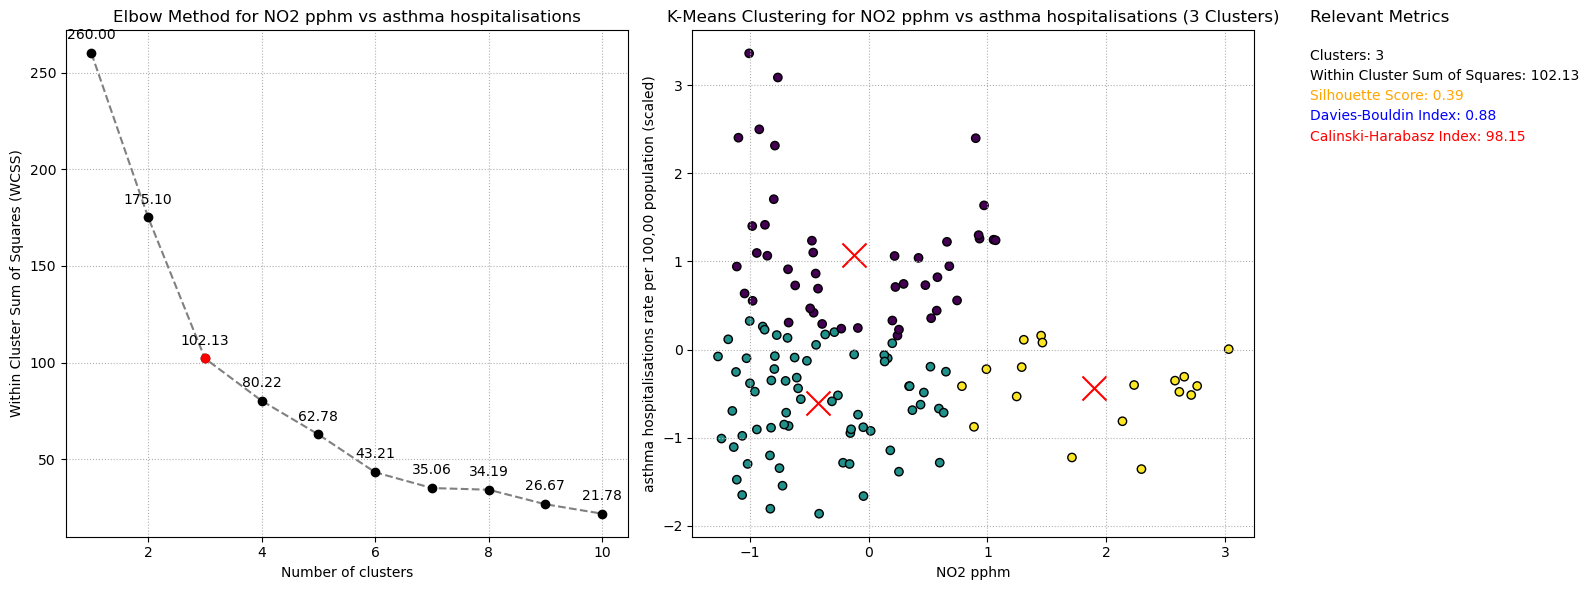

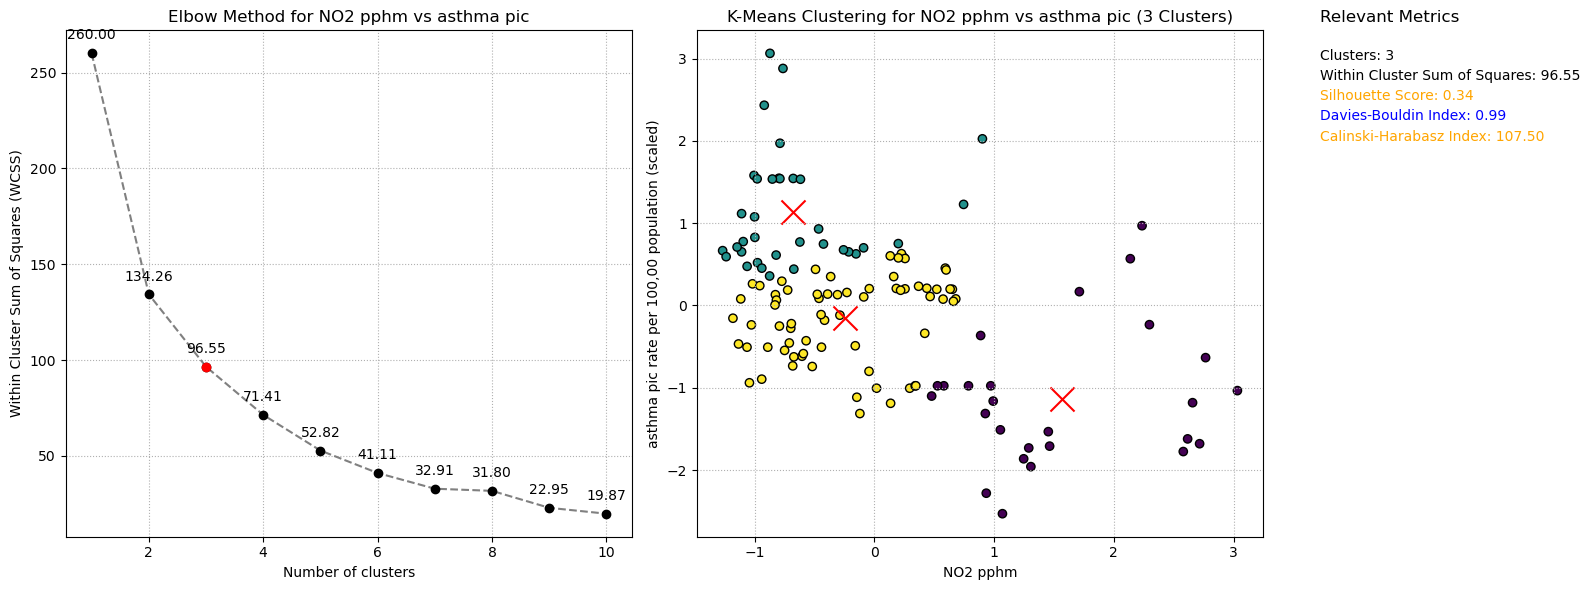

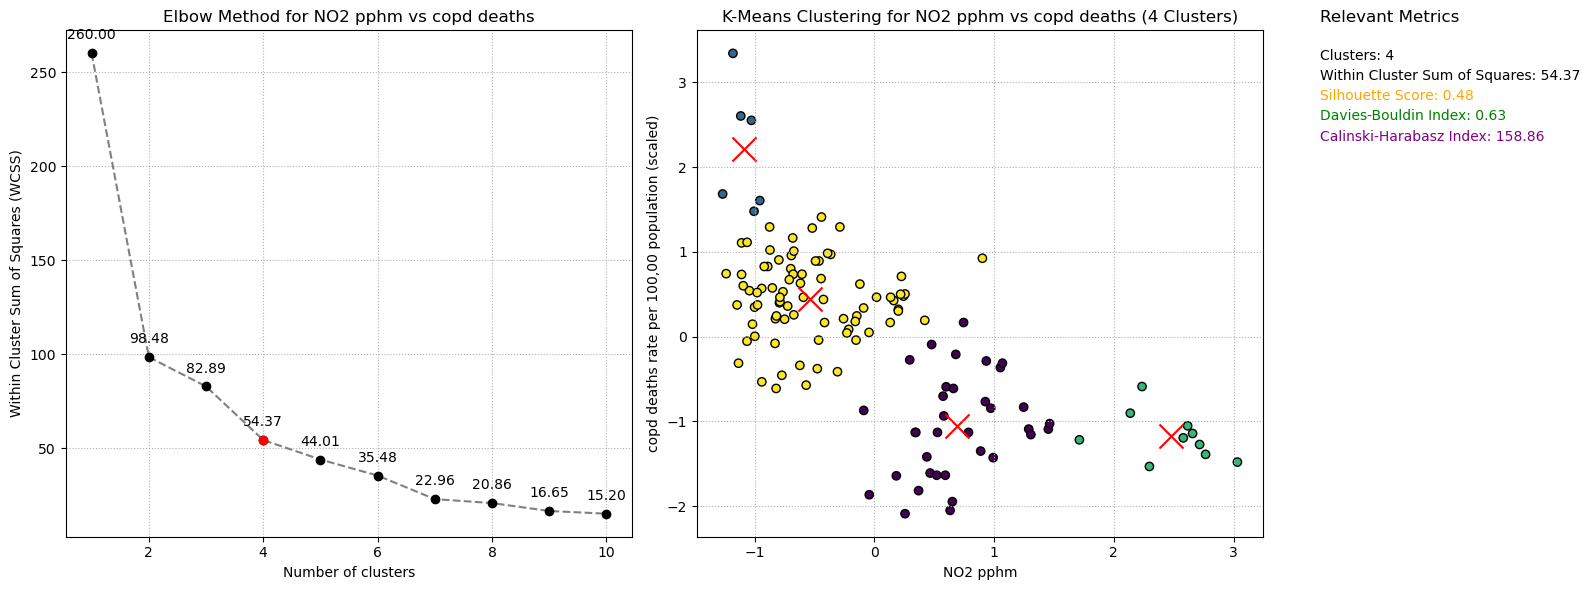

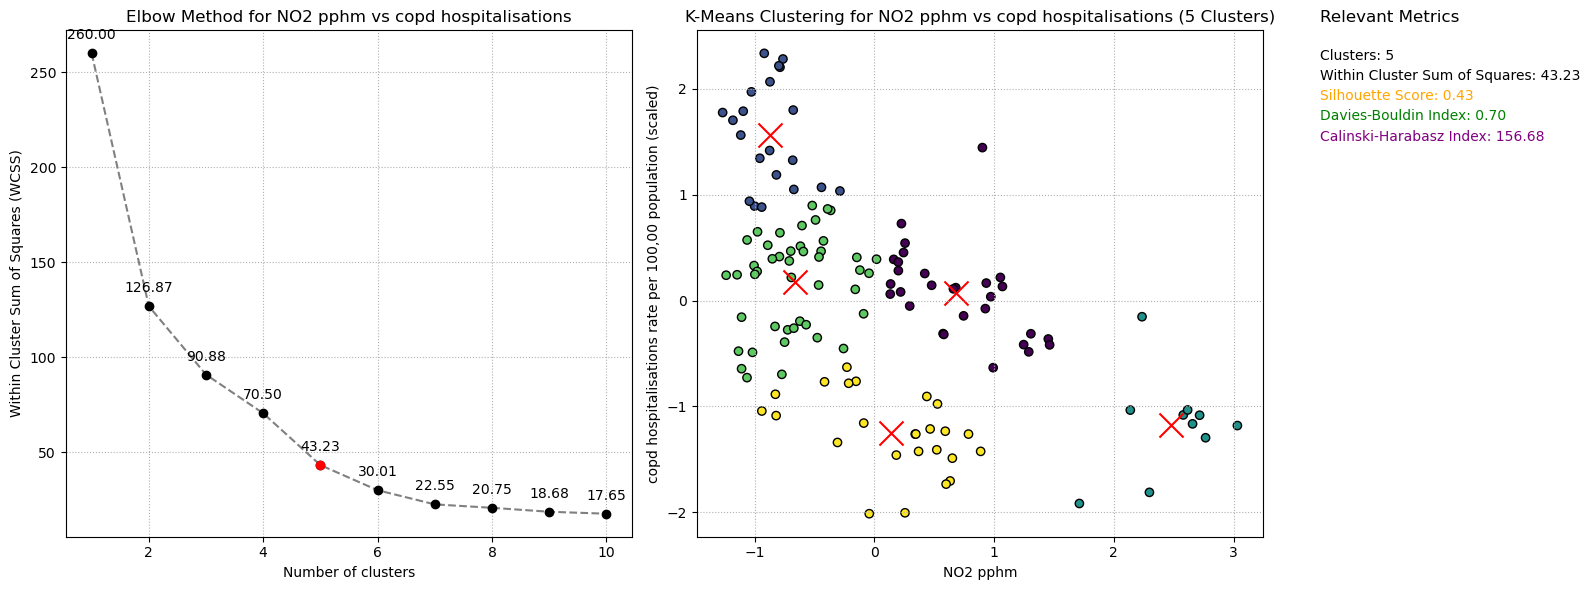

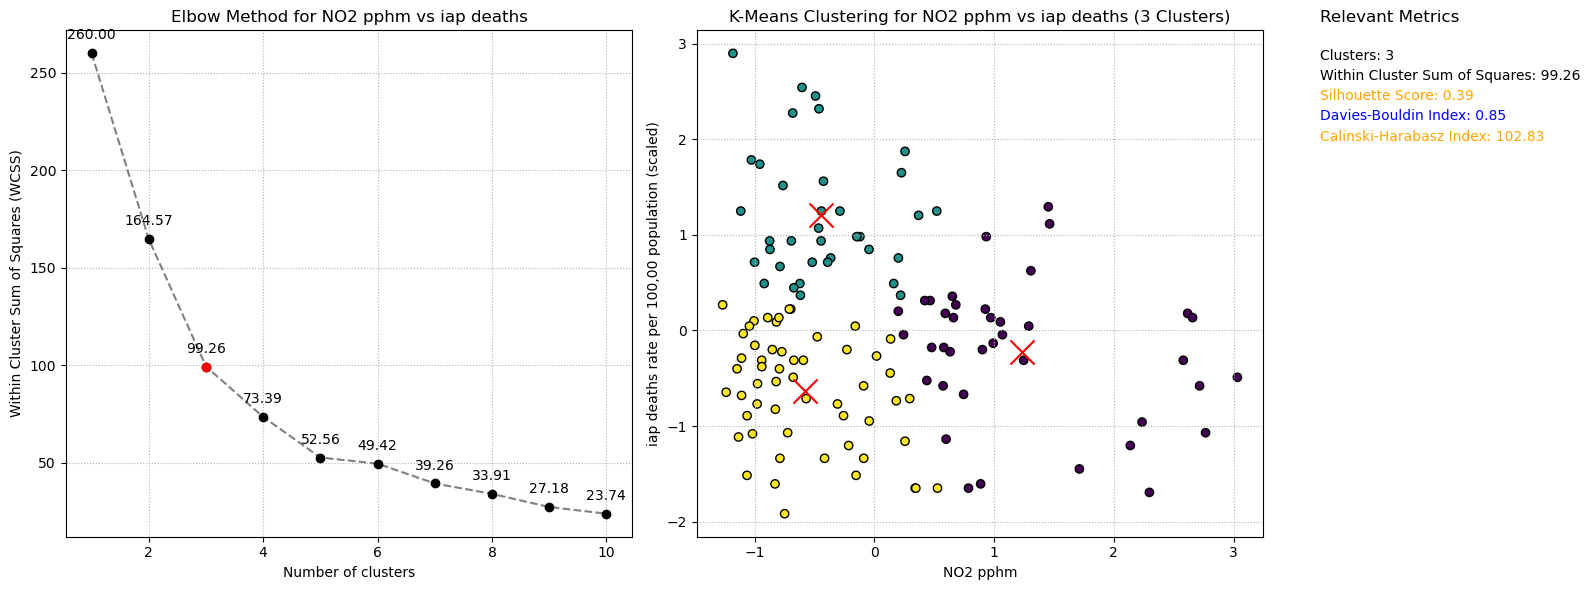

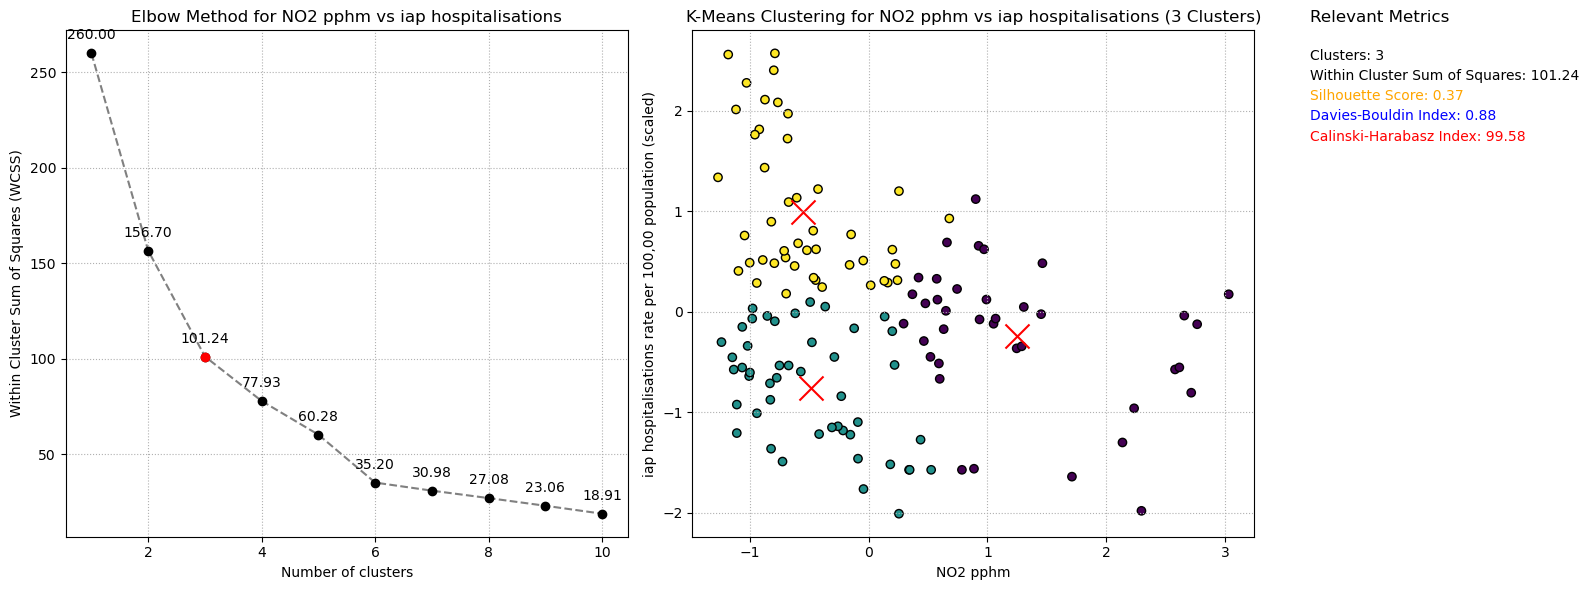

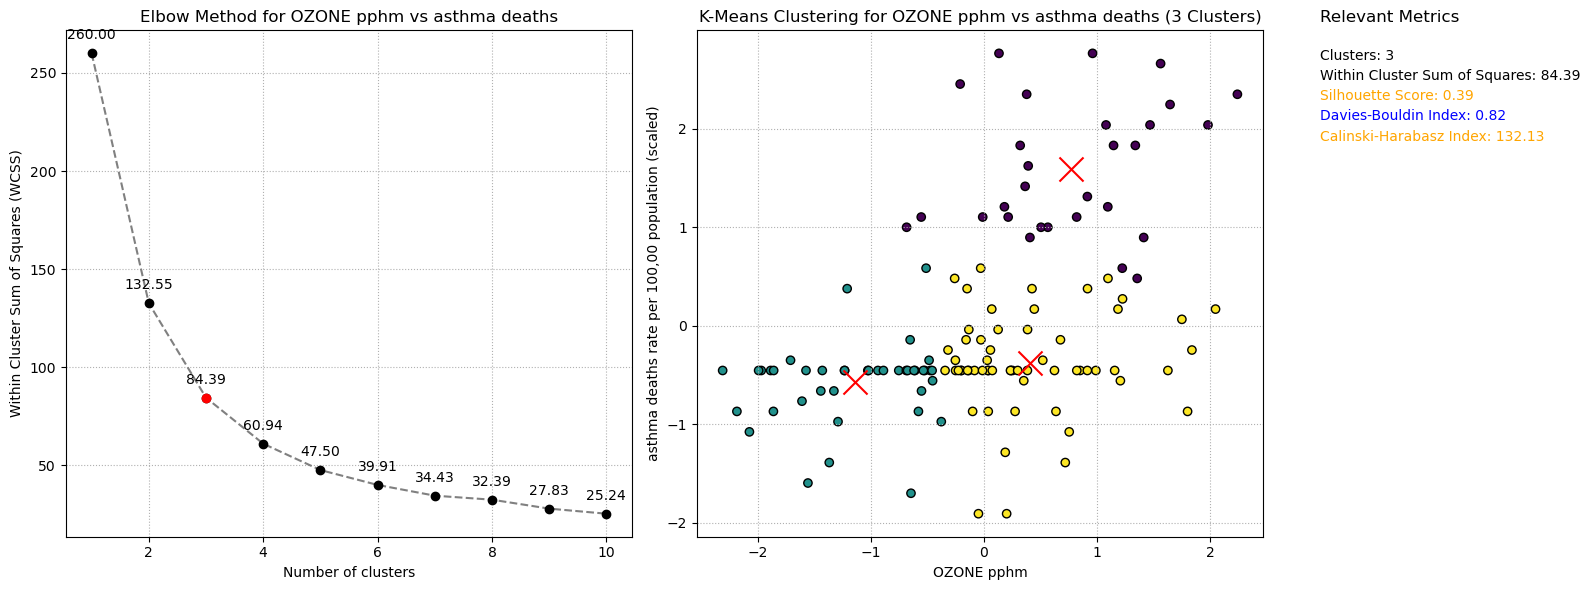

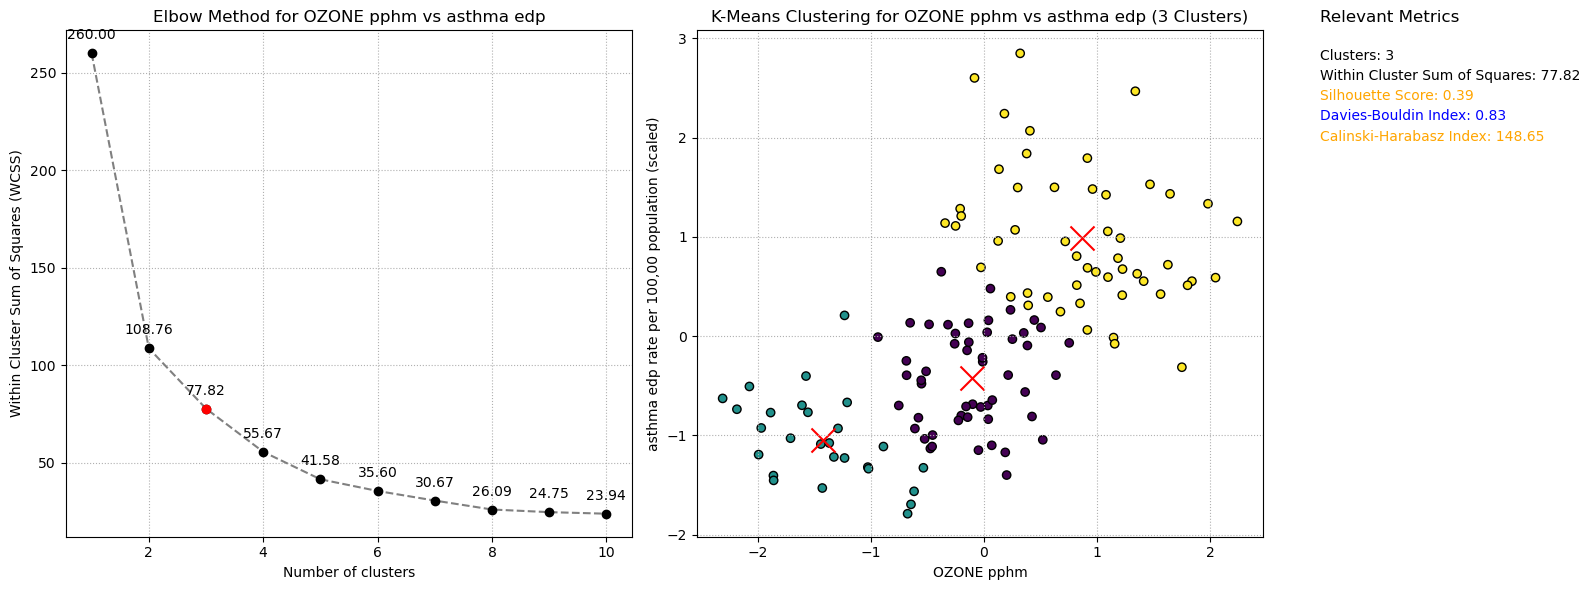

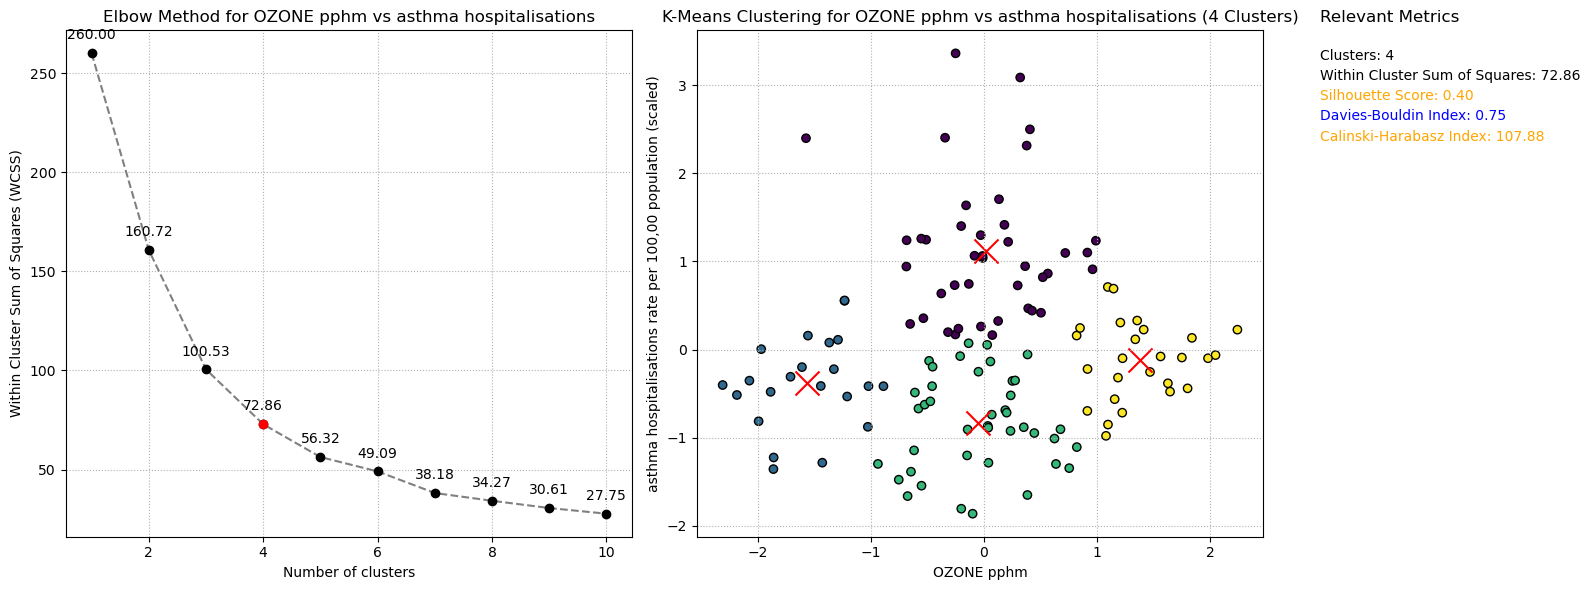

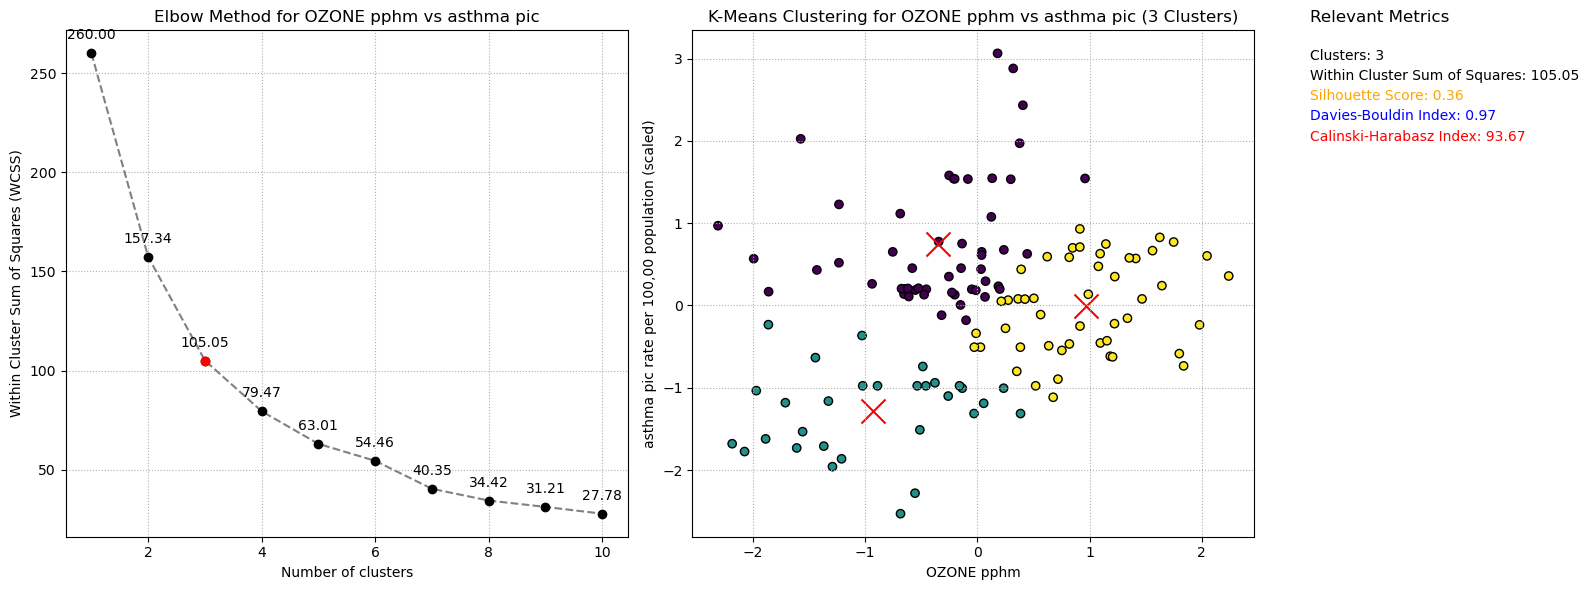

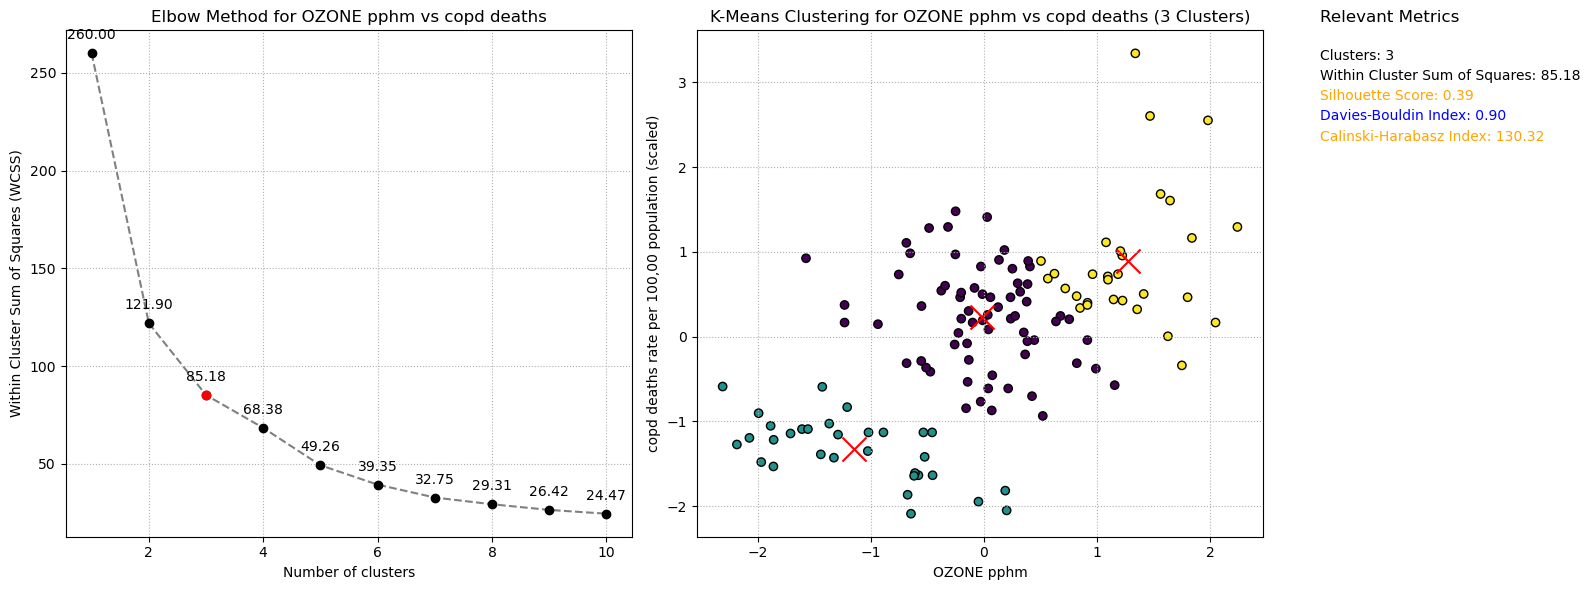

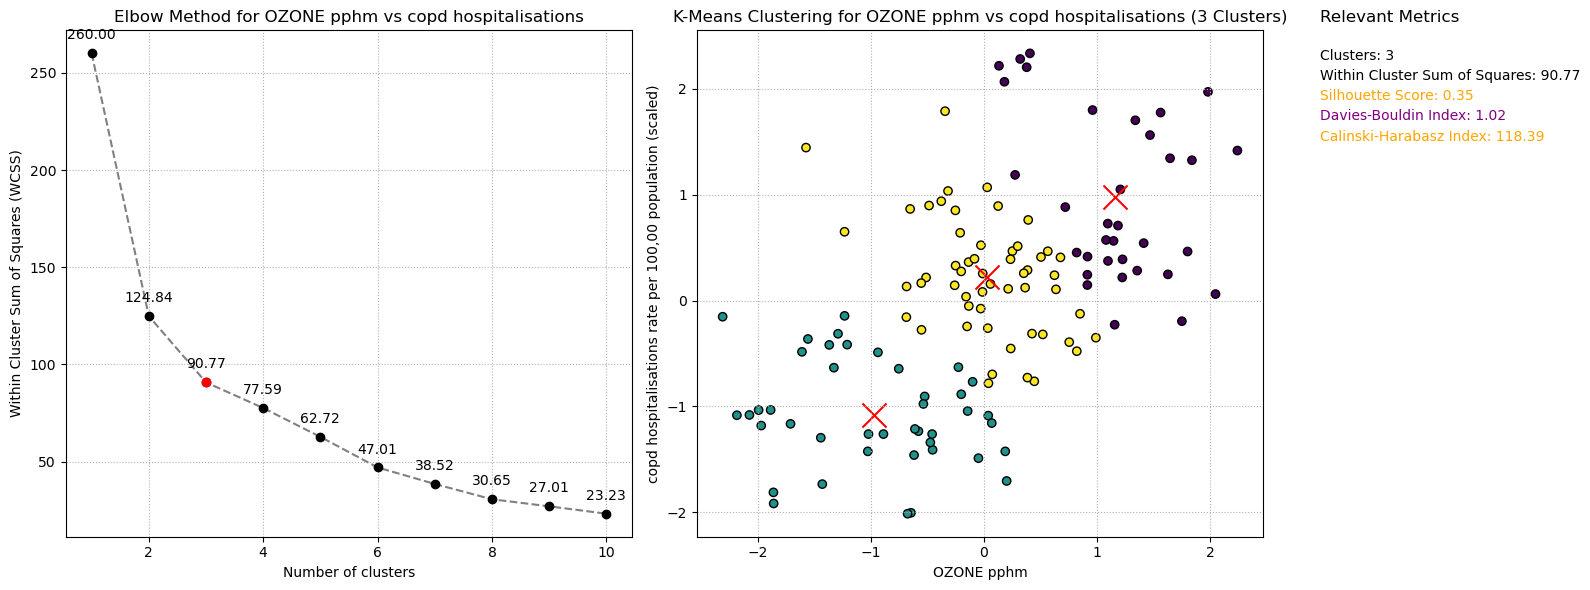

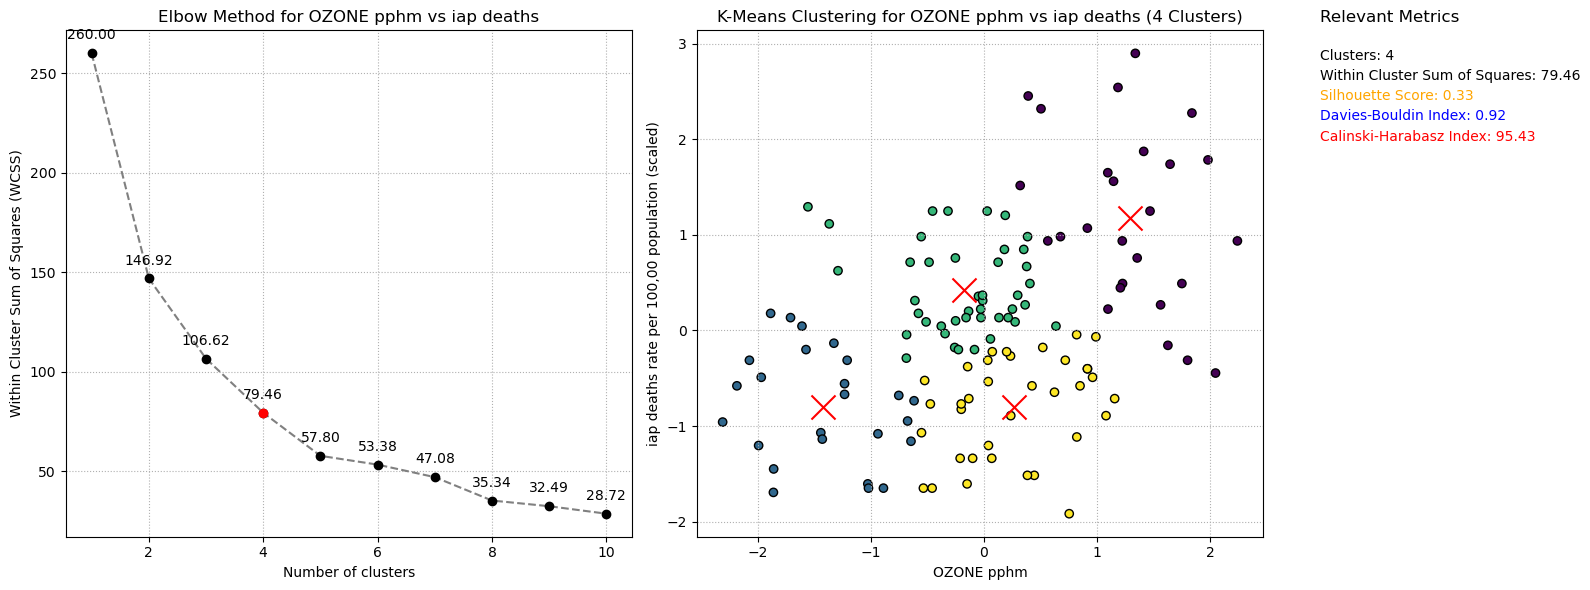

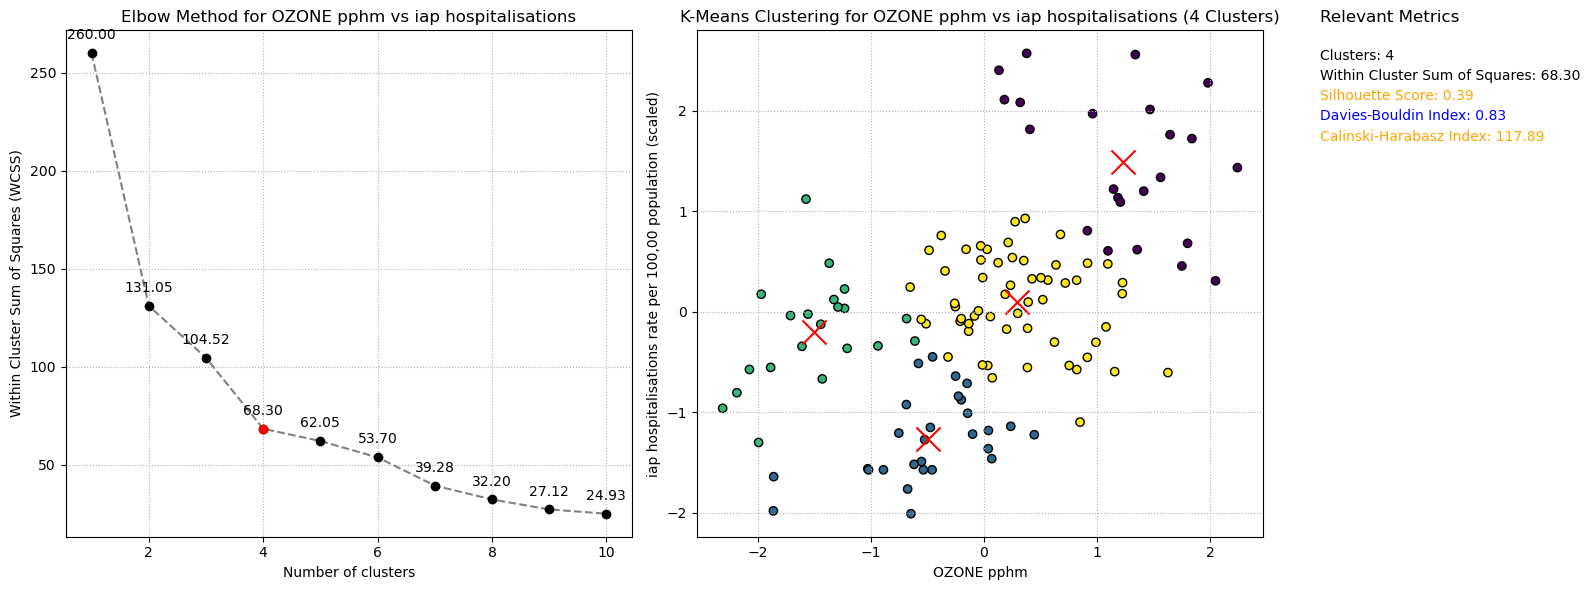

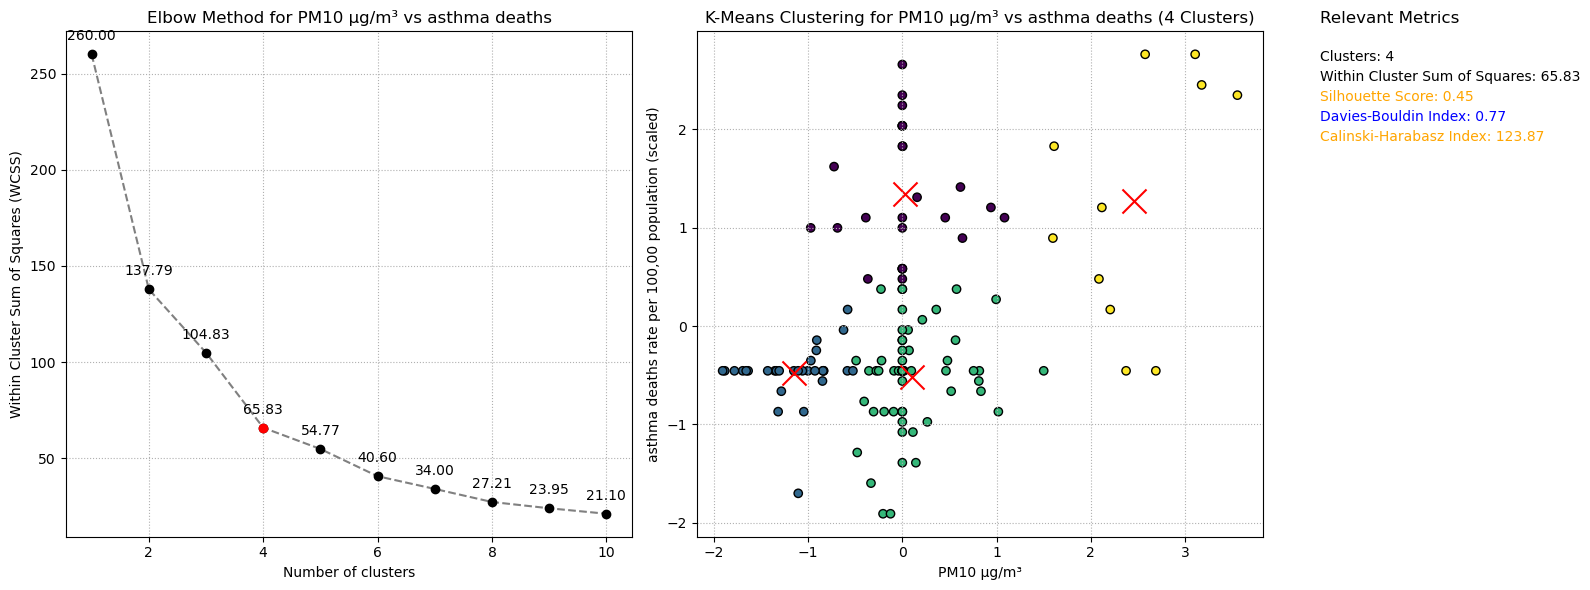

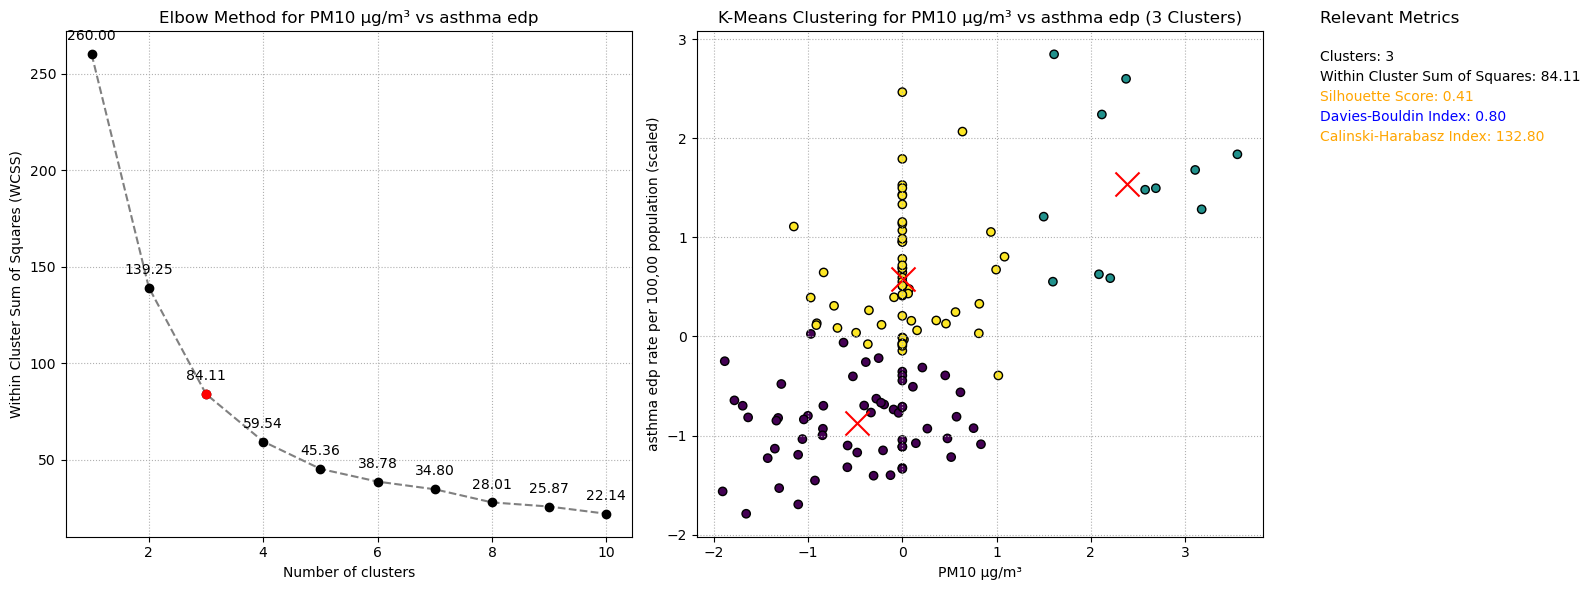

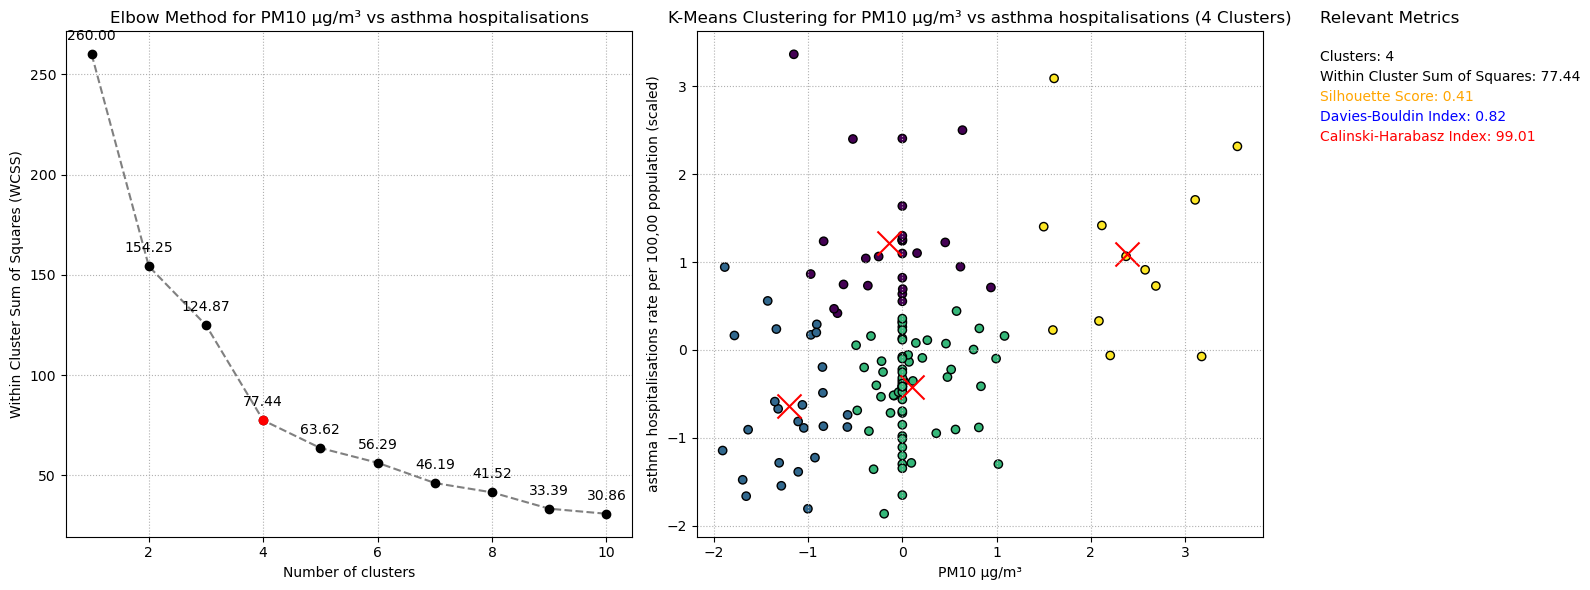

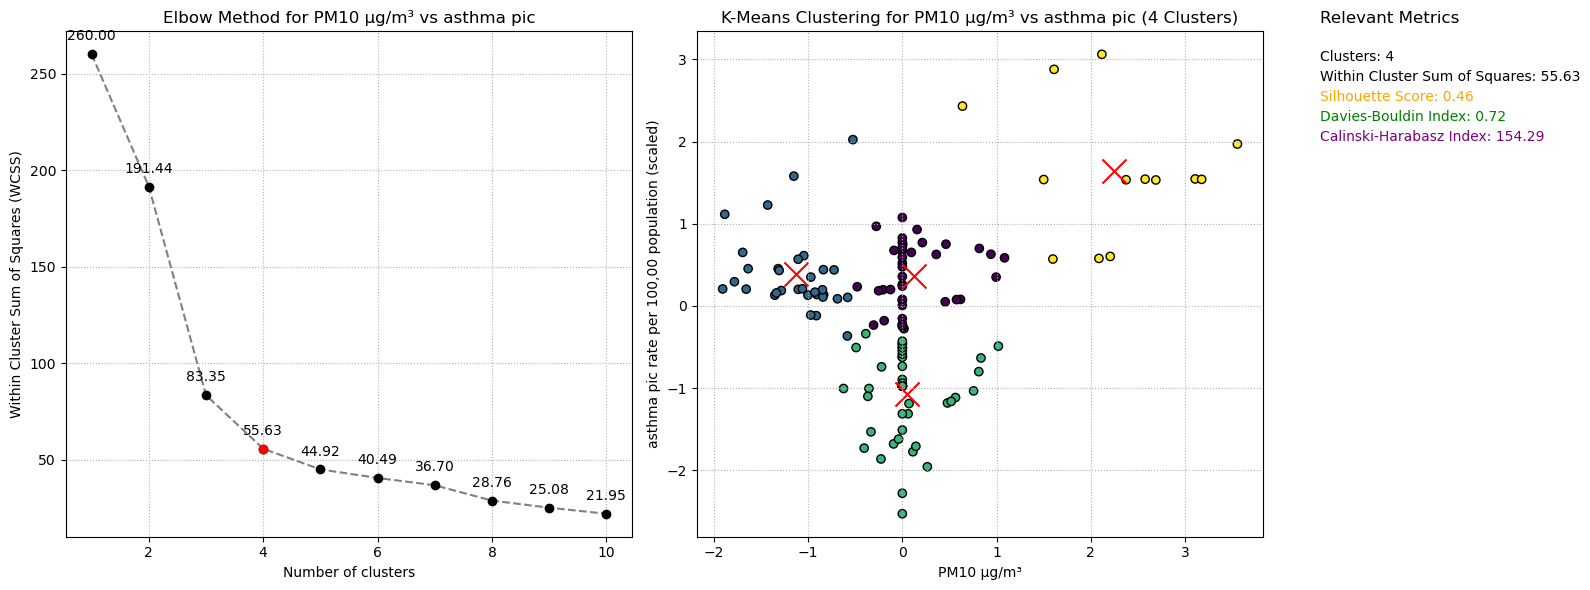

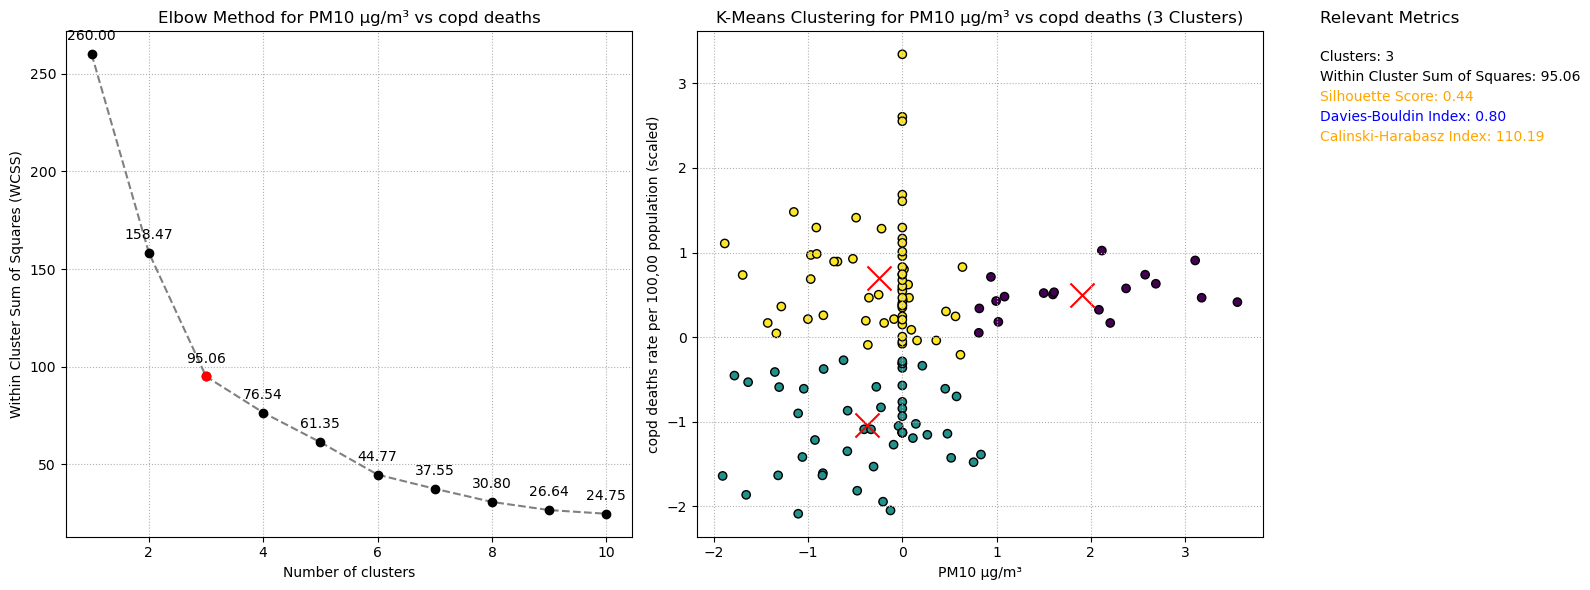

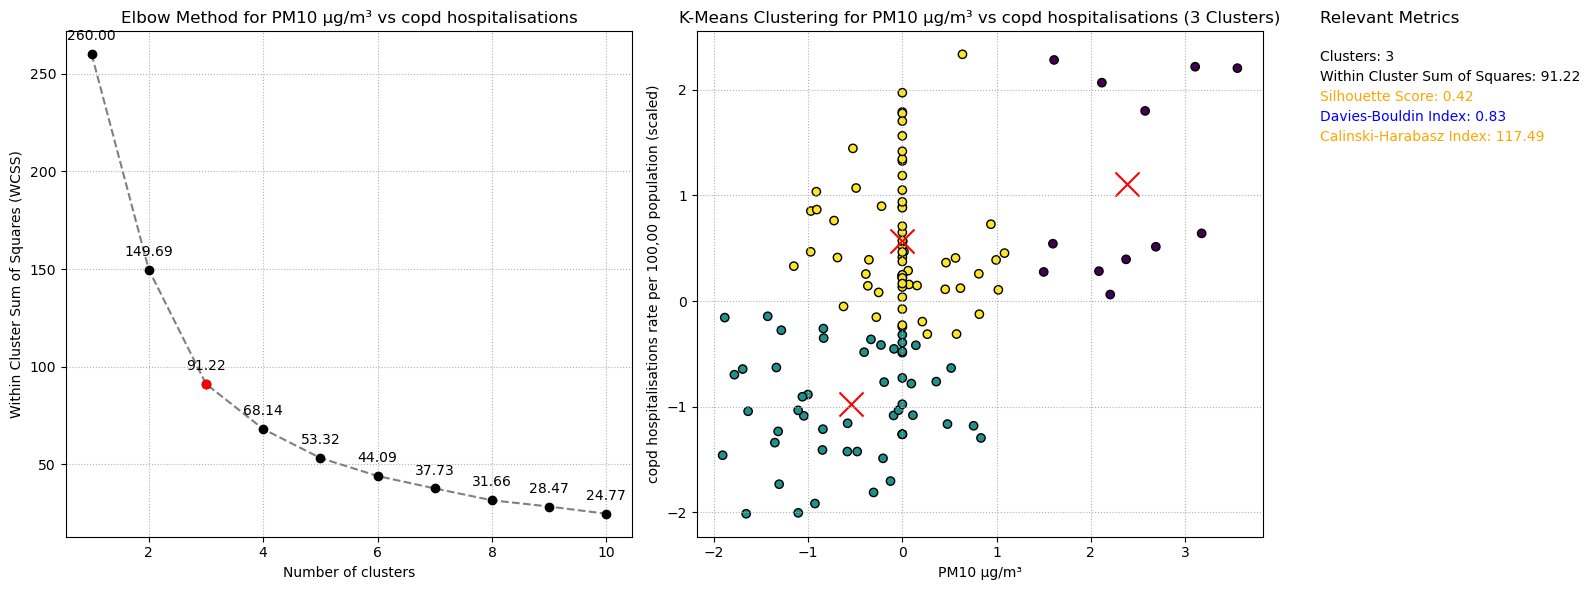

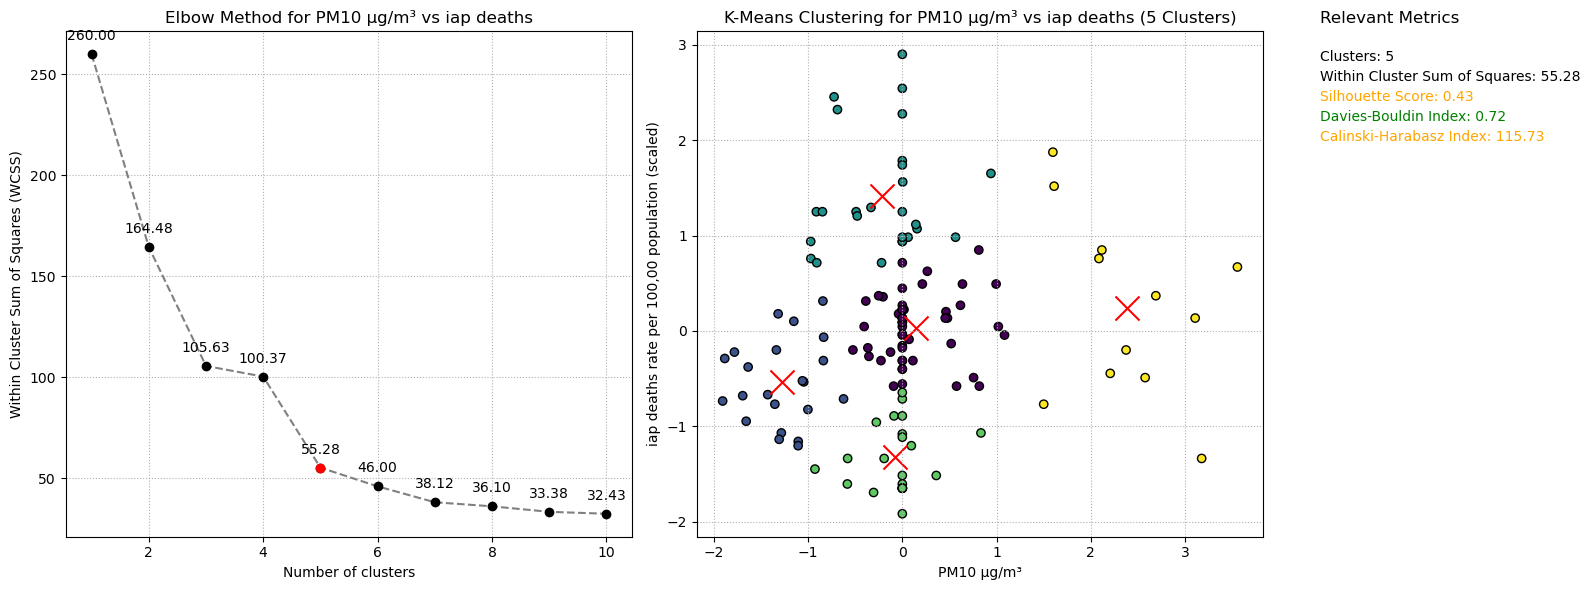

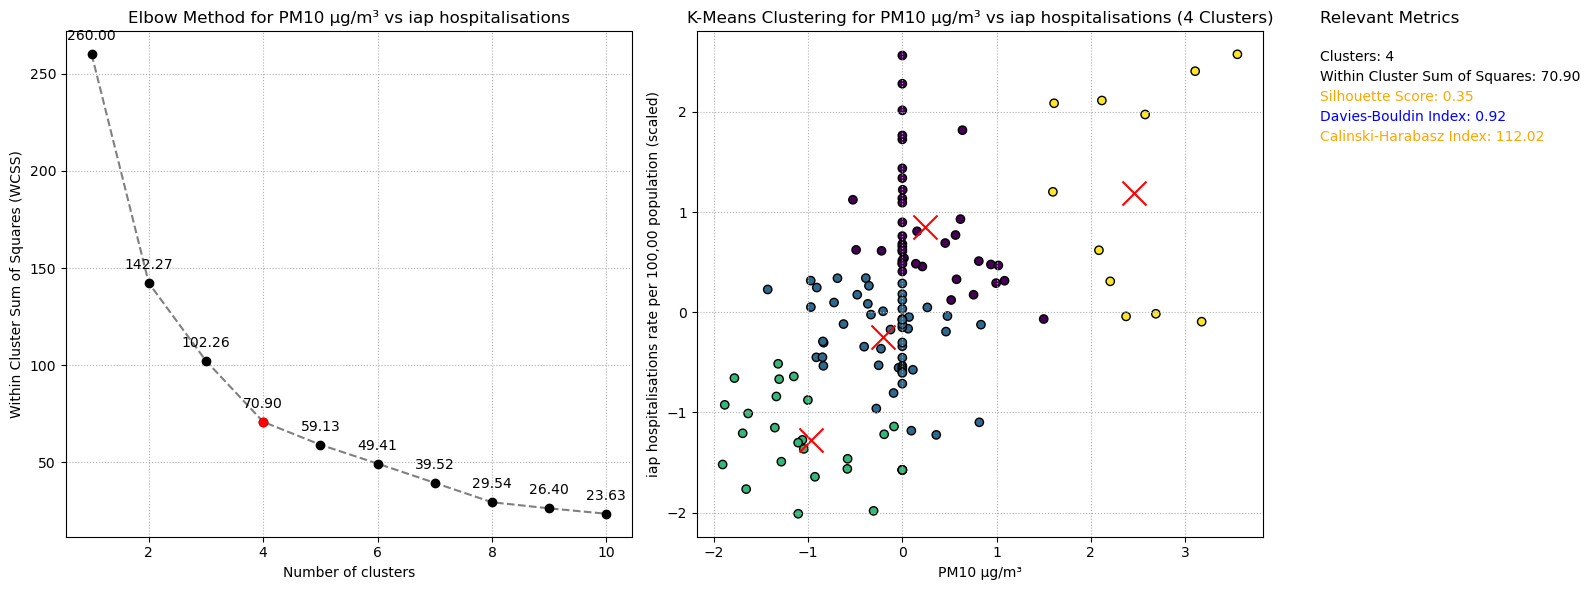

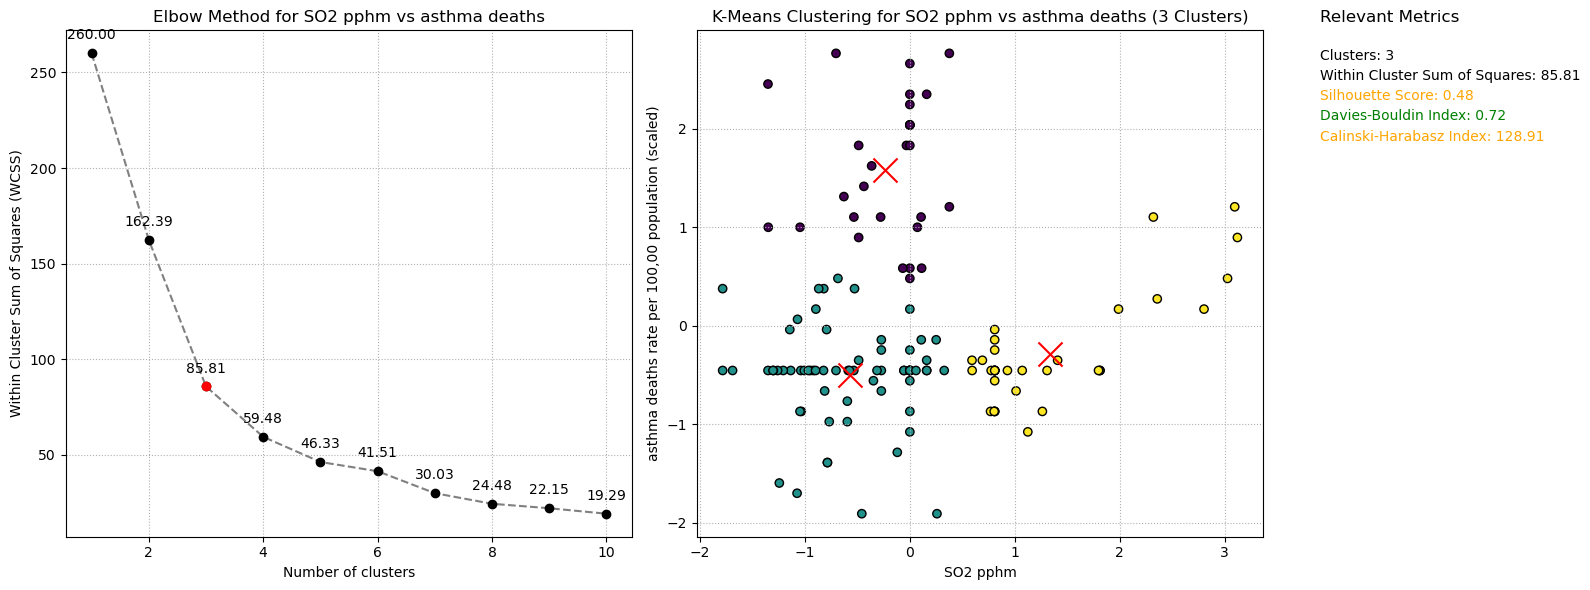

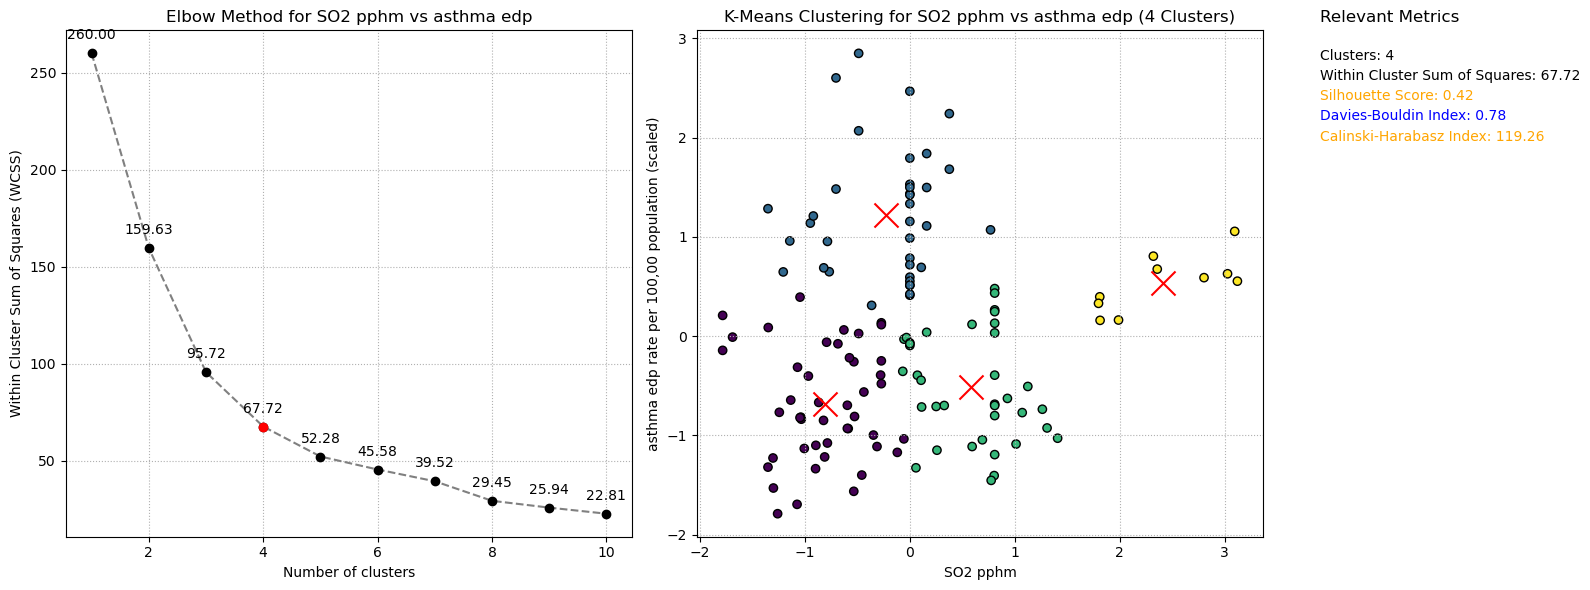

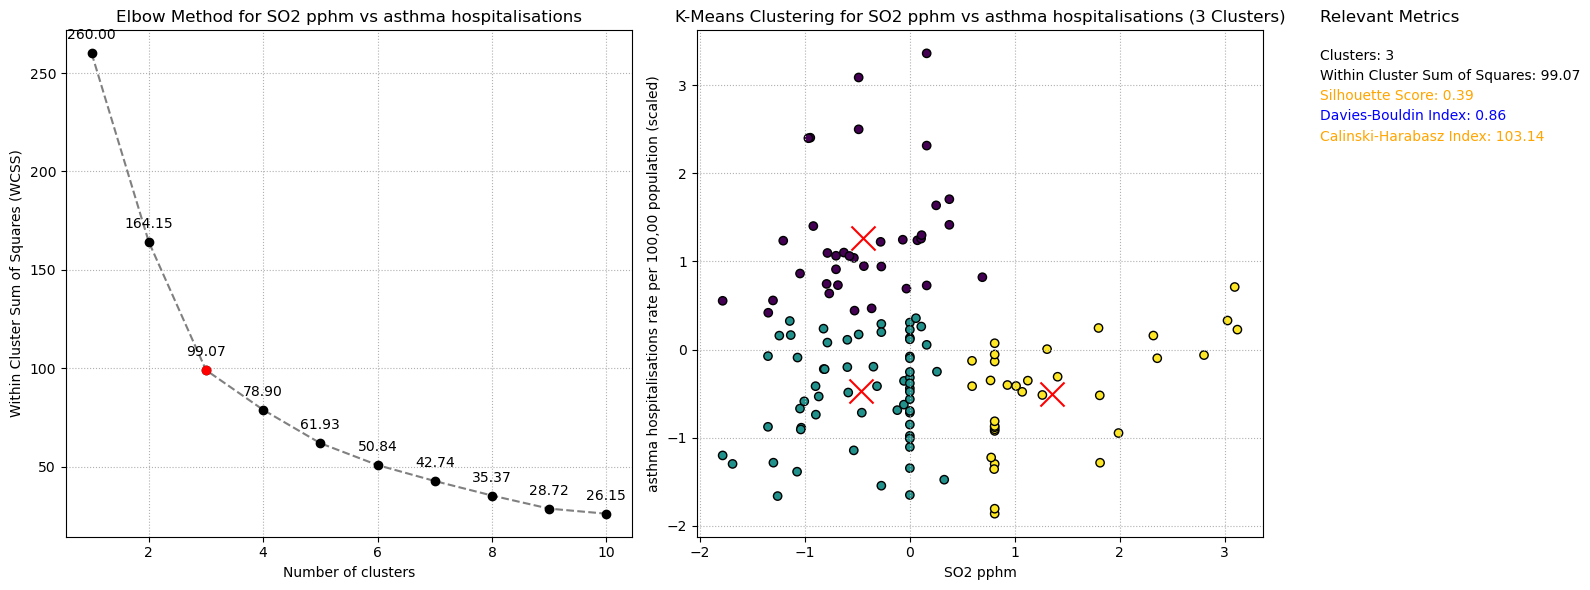

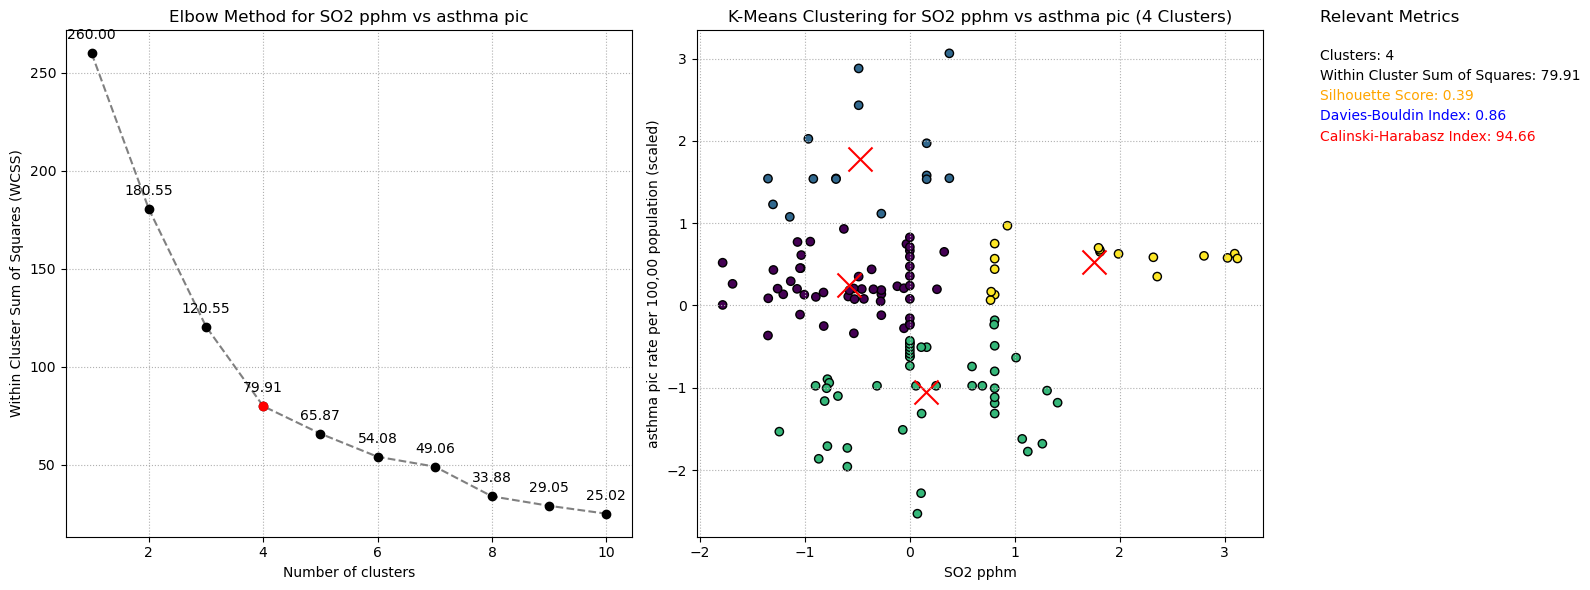

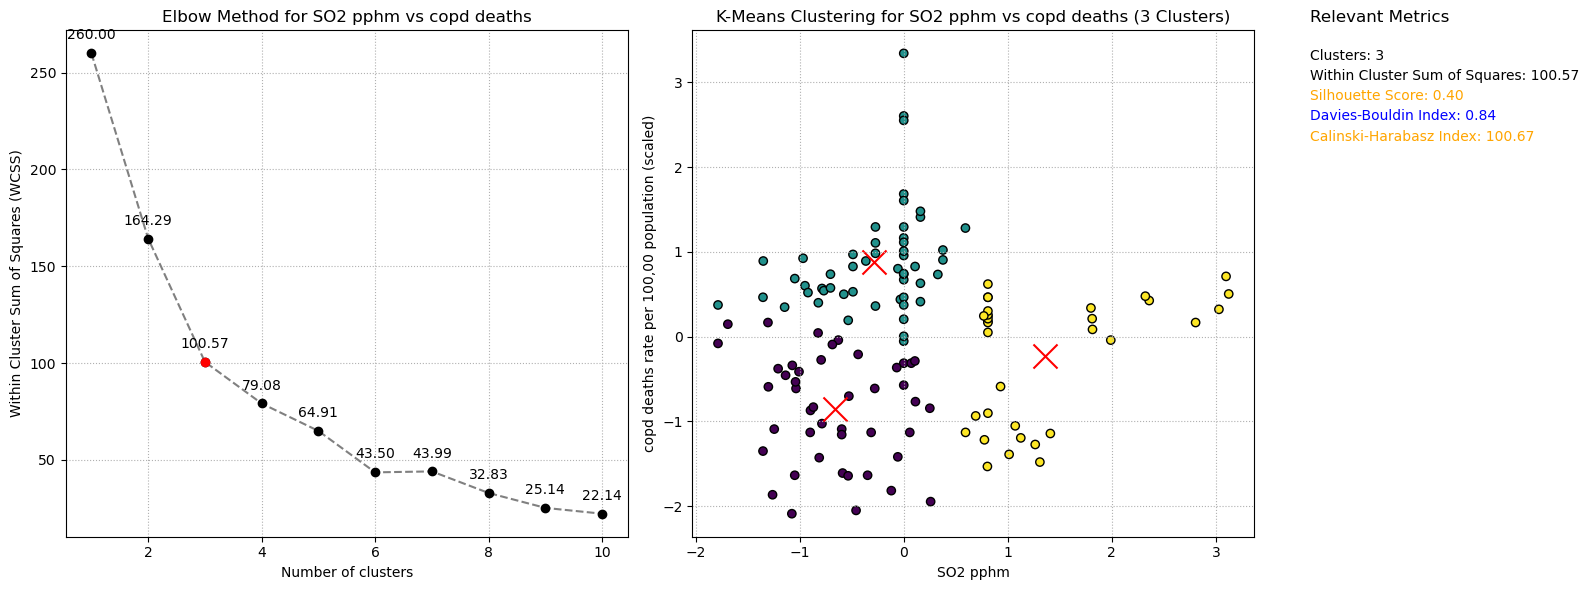

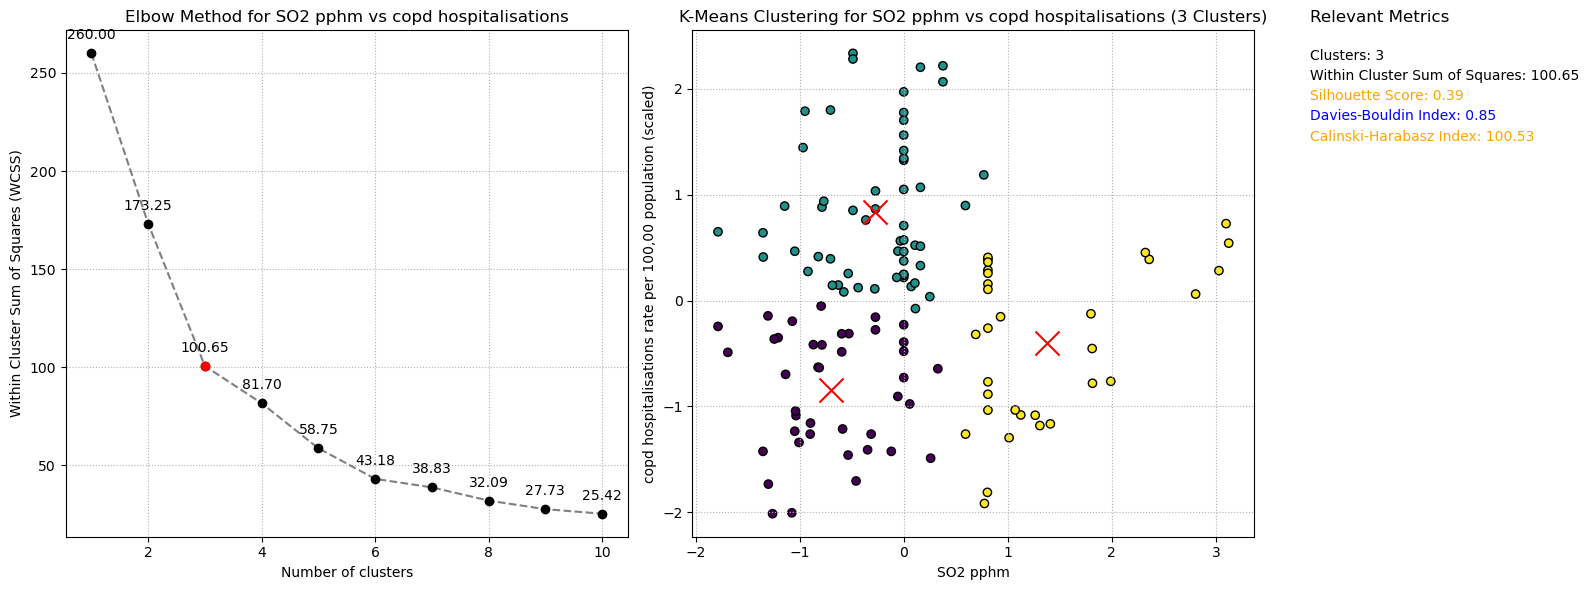

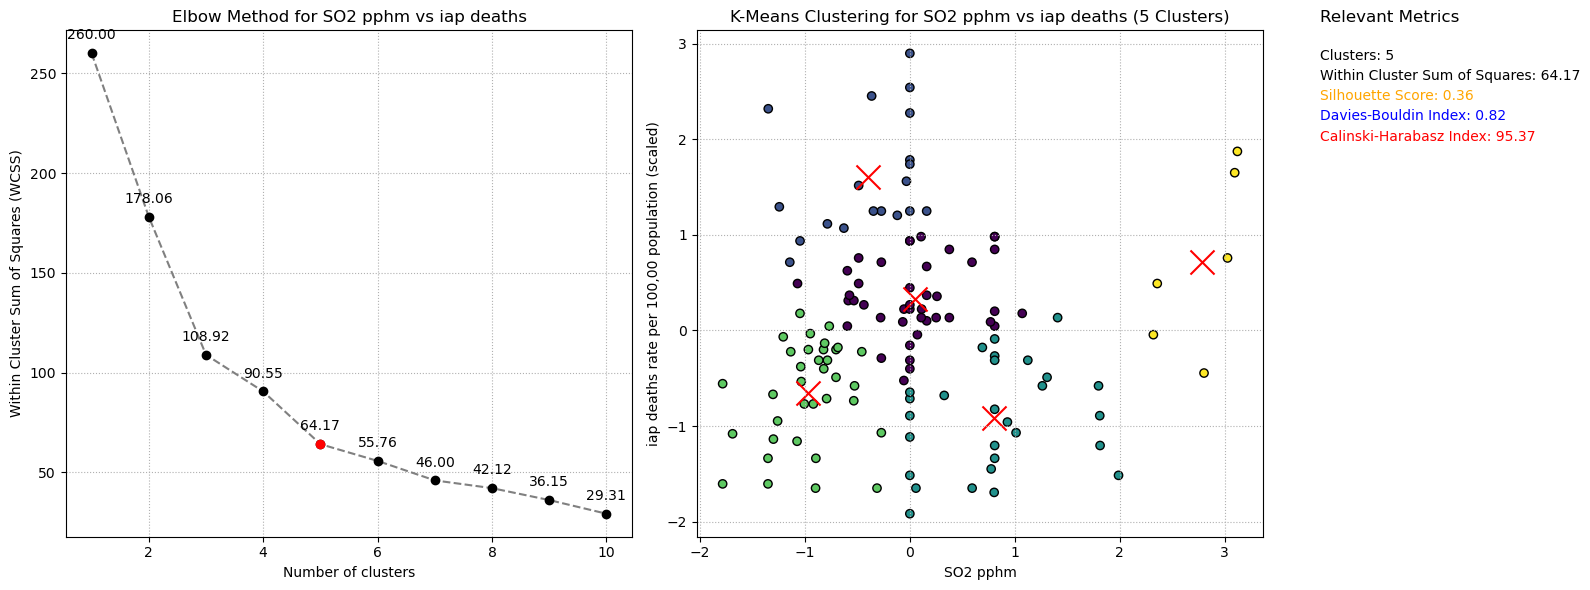

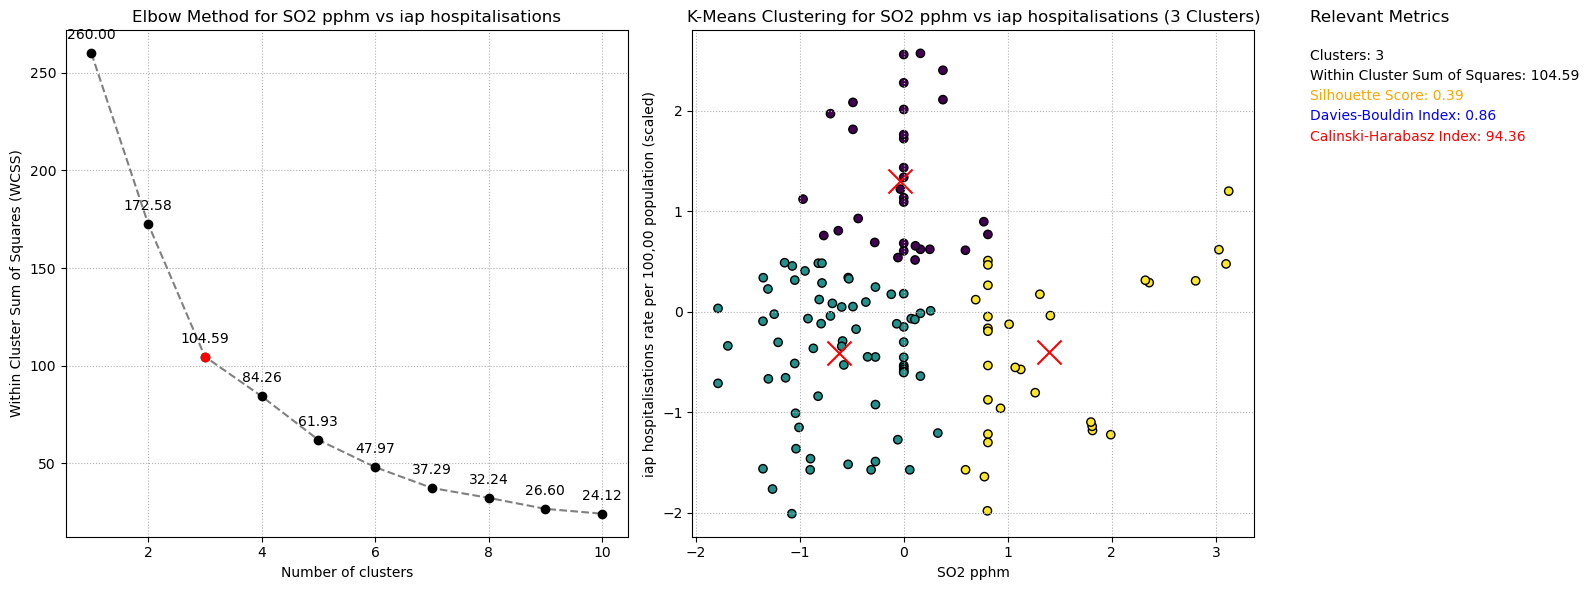

In [396]:
# Display the results for each pair of pollutants and health statistics
for result in results:

    # Set Up
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))                                             # Create a figure with two subplots
    left_align = 1.1                                                                           # Define the left alignment for annotations relative to the right edge of the plot
    top_align = 0.95                                                                           # Define the top alignment for annotations relative to the top edge of the plot
    top_offset = 0.04                                                                          # Define the top offset for annotations

    # Plot the Elbow Method with the knee point
    axs[0].plot(range(1, max_clusters + 1), result['wcss'], '--', color='grey')                                                                # Plot the WCSS values
    axs[0].scatter(range(1, max_clusters + 1), result['wcss'], color='black', zorder=5)                                                        # Plot the WCSS points
    axs[0].set_title(f'Elbow Method for {result["pollutant"]} vs {result["health_stat"]}')                                                     # Set the title of the subplot
    axs[0].set_xlabel('Number of clusters')                                                                                                    # Set the x-axis label
    axs[0].set_ylabel('Within Cluster Sum of Squares (WCSS)')                                                                                  # Set the y-axis label
    axs[0].grid(True, linestyle=':')                                                                                                           # Enable the grid

    # Label each point
    for i, txt in enumerate(result['wcss']):                                                                                                  # Iterate over the WCSS values
        axs[0].annotate(f'{txt:.2f}', (i + 1, txt), textcoords="offset points", xytext=(0, 10), ha='center')                                  # Annotate the graph

    # Highlight the optimal number of clusters
    axs[0].scatter(result['optimal_clusters'], result['wcss'][result['optimal_clusters'] - 1], color='red', zorder=5)                          # Highlight the optimal number of clusters

    # Plot the K-Means clustering in the second subplot
    axs[1].scatter(result['scaled_data'][:, 0], result['scaled_data'][:, 1], c=result['labels'], cmap='viridis', marker='o', edgecolor='k')    # Plot the data points
    axs[1].scatter(result['cluster_centers'][:, 0], result['cluster_centers'][:, 1], s=300, c='red', marker='x')                               # Plot the cluster centers
    axs[1].set_title(f'K-Means Clustering for {result["pollutant"]} vs {result["health_stat"]} ({result["optimal_clusters"]} Clusters)')       # Set the title of the subplot
    axs[1].set_xlabel(result['pollutant'])                                                                                                     # Set the x-axis label
    axs[1].set_ylabel(f'{result['health_stat']} rate per 100,00 population (scaled)')                                                          # Set the y-axis label 
                                                                                                                                               # TODO: Add legend.
    axs[1].grid(True, linestyle=':')                                                                                                           # Enable the grid

    # Set display colors for annotations
    if (result["silhouette"]) < 0.25: silhouette_color = 'red'
    elif (result["silhouette"]) < 0.5: silhouette_color = 'orange'
    elif (result["silhouette"]) < 0.7: silhouette_color = 'purple'
    elif (result["silhouette"]) < 0.85: silhouette_color = 'blue'
    else: silhouette_color = 'green'

    if (result["db_score"]) > 2: db_color = 'red'
    elif (result["db_score"]) > 1.5: db_color = 'orange'
    elif (result["db_score"]) > 1: db_color = 'purple'
    elif (result["db_score"]) > 0.75: db_color = 'blue'
    else: db_color = 'green'

    if (result["ch_score"]) < 100: ch_color = 'red'
    elif (result["ch_score"]) < 150: ch_color = 'orange'
    elif (result["ch_score"]) < 200: ch_color = 'purple'
    elif (result["ch_score"]) < 250: ch_color = 'blue'
    else: ch_color = 'green'


    # Add annotations with the metrics
    annotations = [
        ("Relevant Metrics", 1.025, 12, 'black'),
        (f'Clusters: {result["optimal_clusters"]}', top_align, 10, 'black'),
        (f'Within Cluster Sum of Squares: {result["wcss"][result["optimal_clusters"] - 1]:.2f}', top_align - top_offset, 10, 'black'),
        (f'Silhouette Score: {result["silhouette"]:.2f}', top_align - top_offset * 2, 10, silhouette_color),
        (f'Davies-Bouldin Index: {result["db_score"]:.2f}', top_align - top_offset * 3, 10, db_color),
        (f'Calinski-Harabasz Index: {result["ch_score"]:.2f}', top_align - top_offset * 4, 10, ch_color)
    ]

    # Annotate the metrics on the K-Means plot
    for text, align, size, text_color in annotations:                                                                                          # Iterate over the annotations
        axs[1].text(left_align, align, text, ha='left', va='center', transform=axs[1].transAxes, fontsize=size, color=text_color)               # Annotate the graph

    # Show the combined plot
    plt.tight_layout()
    plt.show()